Исполняемый код:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

plt.rc('text', usetex=True)

# принято считать, что недель в году 52, но надо же куда-то деть последние дни
WEEK_LENGTH, WEEKS_NUMBER = 7, 53
MONTHS_NUMBER, DAYS_NUMBER = 12, 365
BEGIN, END = 1818, 2018
FOUR_YEARS = 1461
YEAR_DAYS = np.array(range(1, DAYS_NUMBER + 1))

months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

DPI = 80
SIZE_X, SIZE_Y = 15, 5

In [2]:
# вспомогательные функции для работы с датами

def GetDayNumber(month, day):
    day_number = day - 1
    for i in range(month - 1):
        day_number += months[i]
    return day_number

def GetDate(day):
    month = 0
    while month < len(months) and day >= months[month]:
        day -= months[month]
        month += 1
    return (month + 1, day + 1)

def GetWeekNumber(day):
    return day // WEEK_LENGTH

In [3]:
# осреднить солнечные данные по 4м годам
# нарисовать график солнечной активности

f_in = open("solar_data.txt", "r")

queue, day_spots, years, dates = [], [], [], []
year_spots = np.zeros(END - BEGIN + 1)
first_date, date_by_number = dict(), dict()

cur_sum, amount_mesaruments = 0, 0

for line in f_in:
    row = list(map(float, line.split()[:7]))
    year, month, day, spots = int(row[0]), int(row[1]), int(row[2]), row[4]
    
    # нужно сложить день в очередь, включая 29 февраля
    if not row[-1]: # измерений не было
        queue.append((year, month, day, -1))
    else:
        amount_mesaruments += 1
        queue.append((year, month, day, spots))
        cur_sum += spots
    
    if len(queue) == FOUR_YEARS:
        n = len(day_spots) # "номер" измерения
        year, month, day = queue[FOUR_YEARS // 2][:3]
        cur_spots = cur_sum / amount_mesaruments
        if (month, day) != (2, 29): # если середина - не 29 февраля
            year_spots[year - BEGIN] += cur_spots
            if year not in first_date:
                first_date[year] = n
            date_by_number[n] = (year, GetDayNumber(month, day))
            day_spots.append(cur_spots)
            
            if ((year - BEGIN) % 20 == 0 and GetDayNumber(month, day) == DAYS_NUMBER // 2):
                years.append(year)
                dates.append(n)
        
        if queue[0][-1] >= 0: # если первое измерение в очереди вообще было
            cur_sum -= queue[0][-1]
            amount_mesaruments -= 1
        queue.pop(0) 
f_in.close()

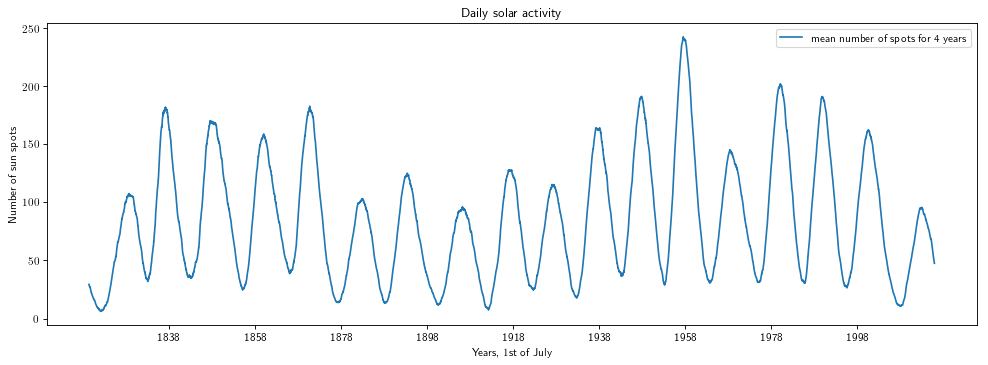

In [4]:
fig = plt.figure(dpi = DPI, figsize = (SIZE_X, SIZE_Y))
plt.title("Daily solar activity")
plt.xlabel("Years, $1$st of July")
plt.ylabel("Number of sun spots")

plt.xticks(dates, years)
plt.plot(np.array(range(len(day_spots))), 
         np.array(day_spots), 
         label="mean number of spots for 4 years")
plt.legend(loc="best")

fig.savefig("pic/cycles.jpg")
plt.show()

In [5]:
# теперь нужно выделить минимумы по годам
# первый пусть будет в 1822
year = 1822
years_of_minimum = [year]    

while year < END:
    while year < END and year_spots[year - BEGIN] <= year_spots[year - BEGIN + 1]:
        year += 1
    while year < END and year_spots[year - BEGIN] >= year_spots[year - BEGIN + 1]:
        year += 1
    years_of_minimum.append(year)

years_of_minimum = years_of_minimum[:-1]

In [6]:
# теперь по минимумам годов найдём дни минимумов солнечных циклов

days_of_minimum = []
for year in years_of_minimum:
    start = first_date[year - 1] if year != years_of_minimum[0] else 0
    finish = first_date[year + 2]
    min_day = start
    for day in range(start, finish):
        if day_spots[day] < day_spots[min_day]:
            min_day = day
    days_of_minimum.append(min_day)

In [7]:
# вспомогательные функции для работы с файлами

def GetFileName(city, case):
    suf = {"max": "X", "min": "N", "mean": "G"}
    return "T{}_{}.txt".format(suf[case], city)

def GetPicFileName(city, case, suf):
    letter = {"max": "X", "min": "N", "mean": "G"}
    return "pic/{}_{}_{}.jpg".format(city, letter[case], suf)

def SkipFirstLines(file):
    cnt = 0
    for line in file:
        cnt += 1
        if cnt == 19:
            return

In [8]:
# разделение циклов на высокую и низкую активность по дням в зависимости от параметра

def GetActivityLevels(alpha):
    low_activity = set()
    high_activity = set()

    for i in range(len(days_of_minimum) - 1):
        start, finish = days_of_minimum[i], days_of_minimum[i + 1]
        spots = []
        for day in range(start, finish):
            spots.append((day_spots[day], day))
        spots.sort()
    
        for j in range(int(len(spots) * alpha)):
            day = spots[j][1]
            if day in date_by_number:
                low_activity.add(date_by_number[day])
            day = spots[len(spots) - 1 - j][1]
            if day in date_by_number:
                high_activity.add(date_by_number[day])

    return (low_activity, high_activity)

In [9]:
def DrawMinMaxTemperatures(city, case, date_by_number, low_activity, high_activity):    
    file_name = GetPicFileName(city, case, "average_diff")
    mesaruments_low = [[] for i in range(DAYS_NUMBER)]
    mesaruments_high = [[] for i in range(DAYS_NUMBER)]
    
    f_in = open(GetFileName(city, case), "r")
    SkipFirstLines(f_in)
    
    for line in f_in:
        row = line.split(",")
        date, temperature = row[2], int(row[3])
        year, month, day = int(date[:4]), int(date[4:6]), int(date[6:])
        
        # проверим, что данные вообще есть
        if int(row[4]) != 9 and (month, day) != (2, 29):
            day = GetDayNumber(month, day)
            if (year, day) in low_activity:
                mesaruments_low[day].append(temperature)
            elif (year, day) in high_activity:
                mesaruments_high[day].append(temperature)
    
    mean_low = [np.mean(mesaruments_low[day]) / 10 for day in range(DAYS_NUMBER)]
    mean_high = [np.mean(mesaruments_high[day]) / 10 for day in range(DAYS_NUMBER)]

    # нарисуем средние температуры для дней с высокой и низкой солнечной активностью
    fig = plt.figure(dpi = DPI, figsize = (SIZE_X, SIZE_Y))
    ax = plt.axes()
    ax.yaxis.grid(True)
    plt.title(city + " average " + case + 
              " $t^{\circ}$ based on 4-year mean solar activity level")
    plt.xlabel("Number of days since January, $1$st")
    plt.ylabel("Mean t, $C^{\circ}$", rotation='horizontal', labelpad=35)    
    plt.plot(YEAR_DAYS, 
             mean_low, 
             color = "blue", 
             label = "low solar activity")
    plt.plot(YEAR_DAYS, 
             mean_high, 
             color = "red", 
             label = "high solar activity")
    plt.legend(loc="best")
    plt.figure()
    fig.savefig("pic/" + city + "_mean_" + case + "_temperature.jpg")

    # нарисуем график разницы температур
    delta_temp = np.array(mean_high) - np.array(mean_low)
    fig = plt.figure(dpi = DPI, figsize = (SIZE_X, SIZE_Y))
    ax = plt.axes()
    ax.yaxis.grid(True)
    plt.title("Temperature difference in " + city)
    plt.xlabel("Number of days since January, $1$st")
    plt.ylabel("$\Delta$ t, $C^{\circ}$", rotation='horizontal', labelpad=10)
    plt.plot(YEAR_DAYS, delta_temp, color = "grey")
    plt.figure()
    plt.show()
    fig.savefig(file_name)
    f_in.close()

In [10]:
# обработка ежедневных температурных данных

def PrintDifferenceDayTemperature(city, case, alpha, date_by_number,
                                 low_activity, high_activity):
    mesaruments_low = [[] for i in range(DAYS_NUMBER)]
    mesaruments_high = [[] for i in range(DAYS_NUMBER)]

    f_in = open(GetFileName(city, case), "r")
    SkipFirstLines(f_in)
    
    for line in f_in:
        row = line.split(",")
        date, temperature = row[2], int(row[3])
        year, month, day = int(date[:4]), int(date[4:6]), int(date[6:])

        if int(row[4]) != 9 and (month, day) != (2, 29):
            day = GetDayNumber(month, day)
            if (year, day) in low_activity:
                mesaruments_low[day].append(temperature)
            elif (year, day) in high_activity:
                mesaruments_high[day].append(temperature)

    mean_low = [np.median(mesaruments_low[day]) for day in range(DAYS_NUMBER)]
    mean_high = [np.median(mesaruments_high[day]) for day in range(DAYS_NUMBER)]
    delta_temp = (np.array(mean_high) - np.array(mean_low)) / 10
    print("alpha =", alpha, 
          "average delta =", np.mean(delta_temp), 
          "median delta =", np.median(delta_temp))

    m_low = np.array([len(mesaruments_low[day]) for day in range(DAYS_NUMBER)])
    m_high = np.array([len(mesaruments_high[day]) for day in range(DAYS_NUMBER)])

    N = 10  # параметр, задающий "ширину" осреднения
    delta_temp = np.concatenate((delta_temp, delta_temp, delta_temp)) # "зациклим" значения
    mean_delta = [np.mean(delta_temp[(i - N):(i + N + 1)]) 
                for i in range(DAYS_NUMBER, DAYS_NUMBER * 2)]
    
    fig = plt.figure(dpi = DPI, figsize = (SIZE_X, SIZE_Y))
    ax1 = plt.axes()
    ax1.yaxis.grid(True)
    plt.title(city + " average "+ case + " temperature differencies")
    plt.xlabel("Number of days since January, $1$st")
    ax1.set_ylabel("$\Delta t$, $C^{\circ}$", rotation='horizontal', labelpad=10)
    ax2 = ax1.twinx()
    ax2.set_ylabel("Mesaruments", rotation='horizontal', labelpad=30)
    line1 = ax1.plot(YEAR_DAYS, mean_delta, label = "$\\alpha$ = " + str(alpha), color="grey")
    line2 = ax2.plot(YEAR_DAYS, m_low, label = "low activity", color = "blue")
    line3 = ax2.plot(YEAR_DAYS, m_high, label = "high activity", color = "red")
    lines = line1 + line2 + line3
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels, loc="upper right", frameon=True)
    plt.show()
    picture_name = GetPicFileName(city, case, "diff_" + str(int(alpha * 100)))
    fig.savefig(picture_name)
    f_in.close()

In [11]:
cities = ["Prague", "Bologna", "Uccle"]
cases = {"Bologna": ["max", "min", "mean"], 
         "Prague": ["max", "min", "mean"], 
         "Uccle": ["max", "min"], 
         "Milan": ["max", "min", "mean"]}
parameters = [0.5, 0.25, 0.1]

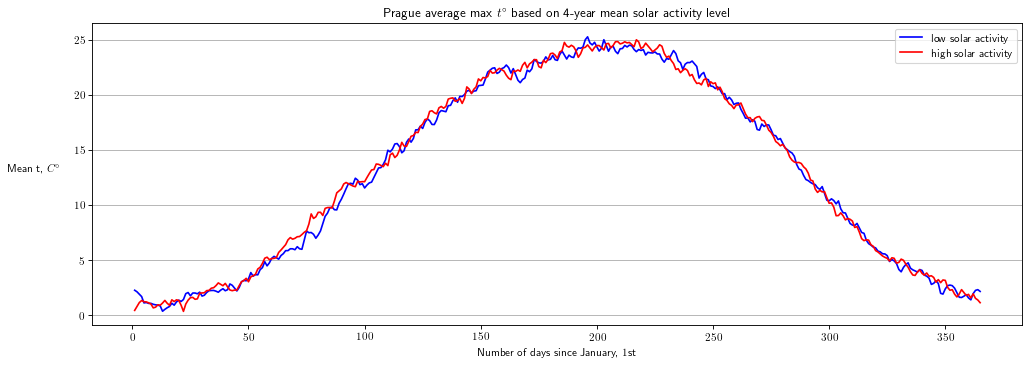

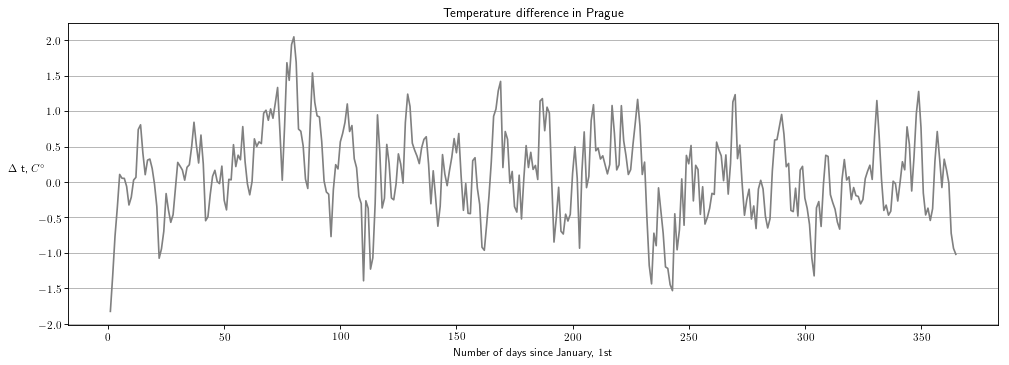

alpha = 0.5 average delta = 0.0797260273973 median delta = 0.05


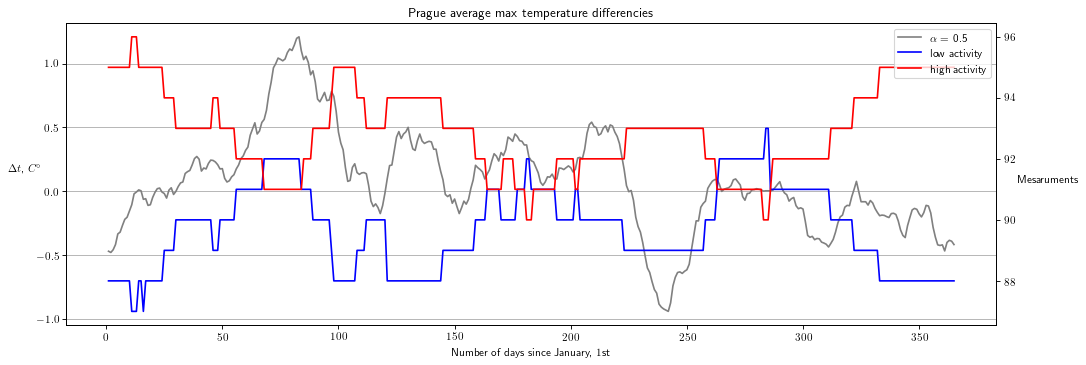

alpha = 0.25 average delta = 0.077397260274 median delta = 0.0


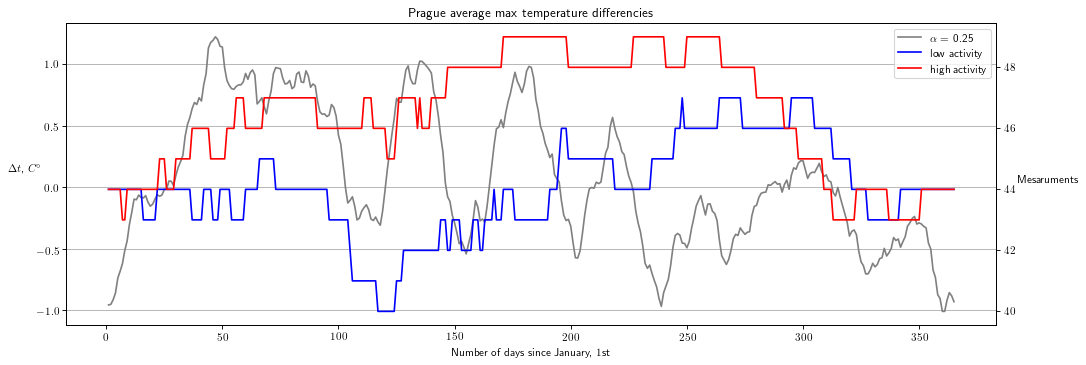

alpha = 0.1 average delta = -0.217808219178 median delta = -0.3


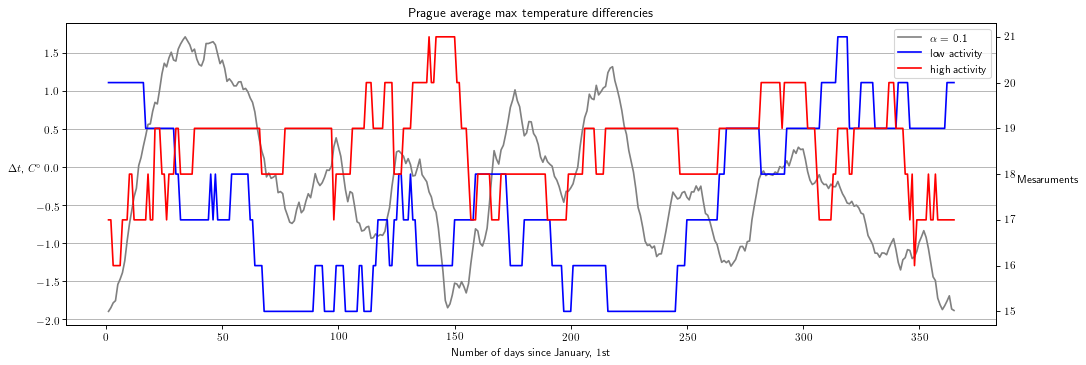

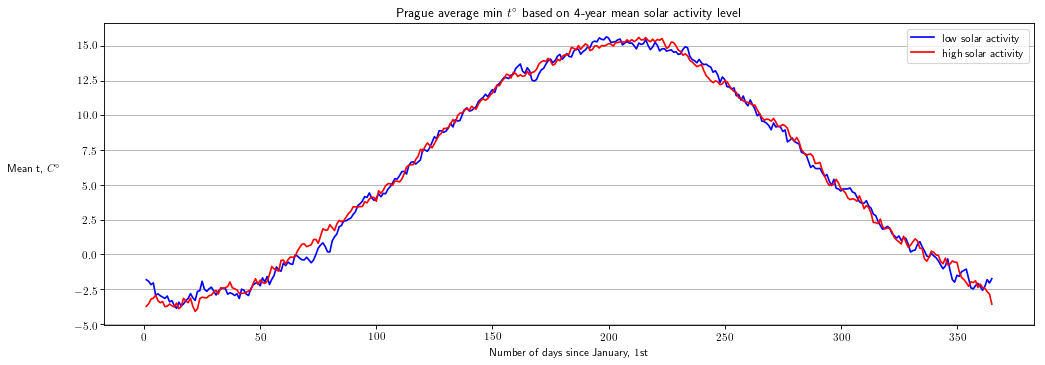

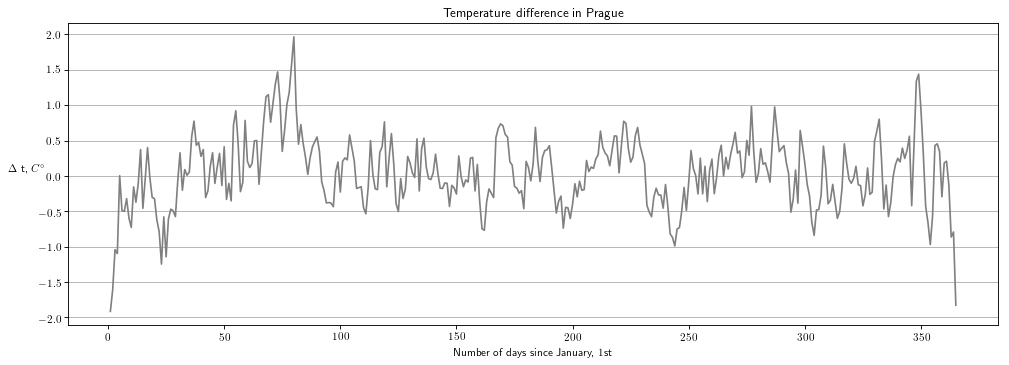

alpha = 0.5 average delta = 0.0412328767123 median delta = 0.05


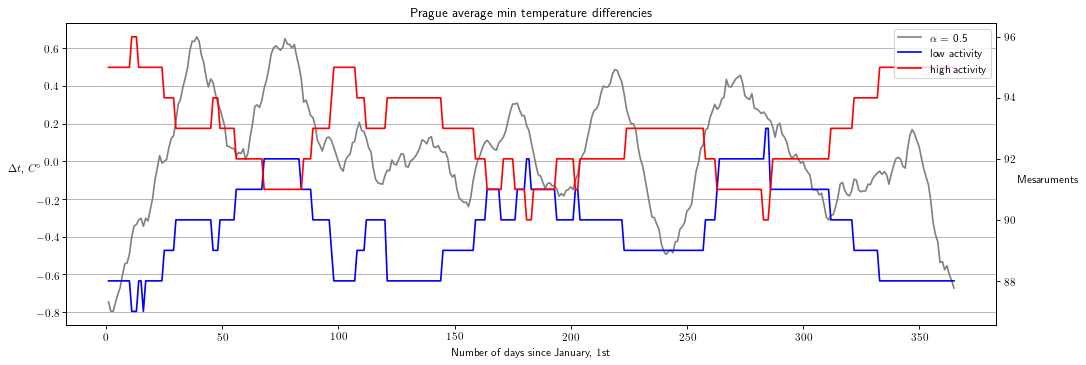

alpha = 0.25 average delta = -0.0160273972603 median delta = -0.05


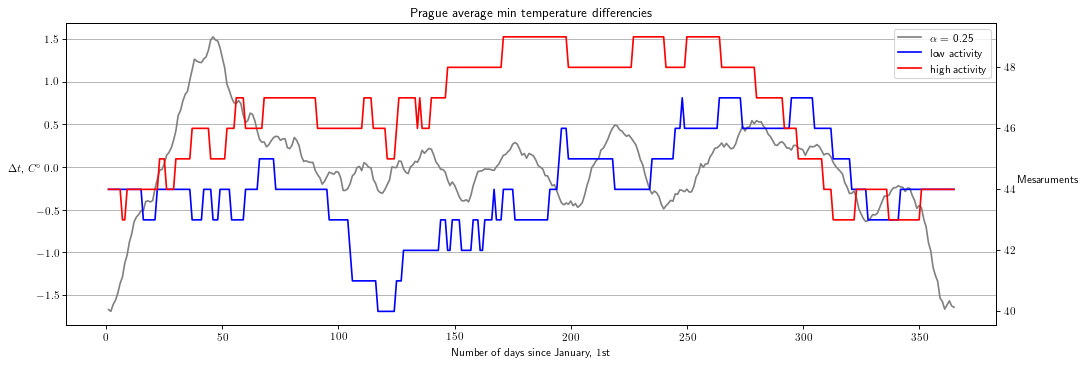

alpha = 0.1 average delta = -0.142739726027 median delta = -0.15


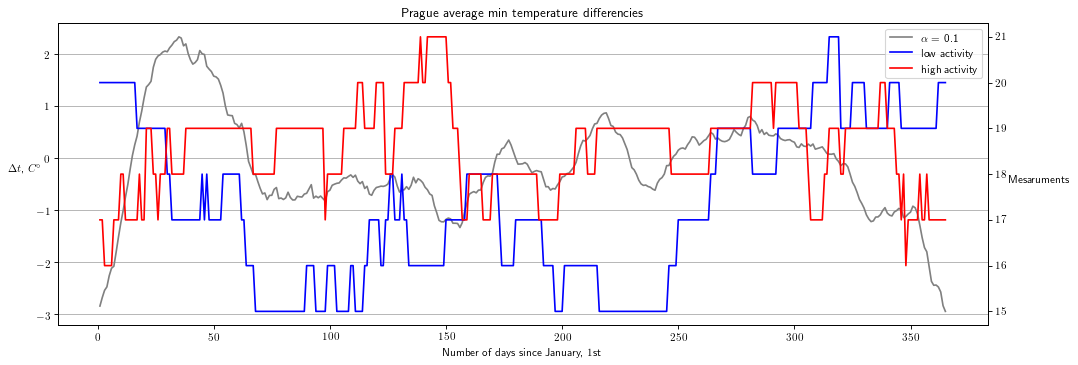

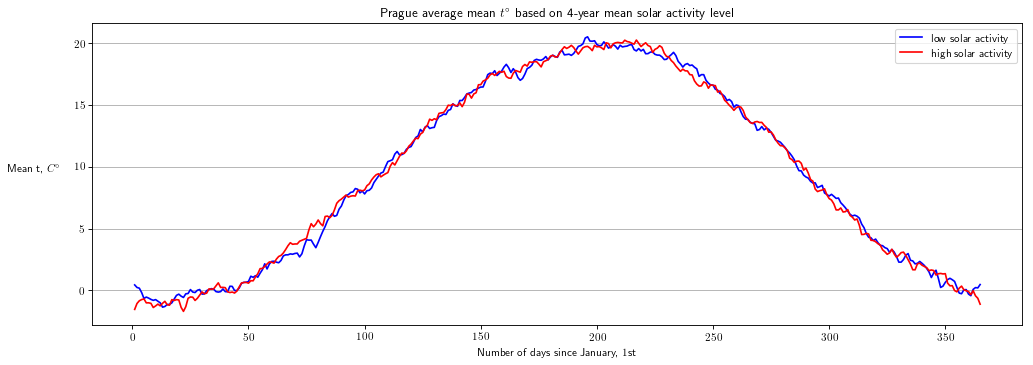

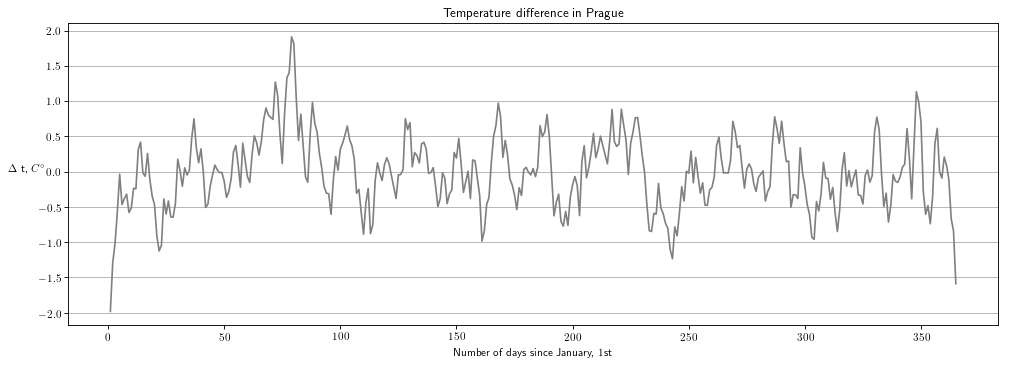

alpha = 0.5 average delta = 0.00520547945205 median delta = 0.05


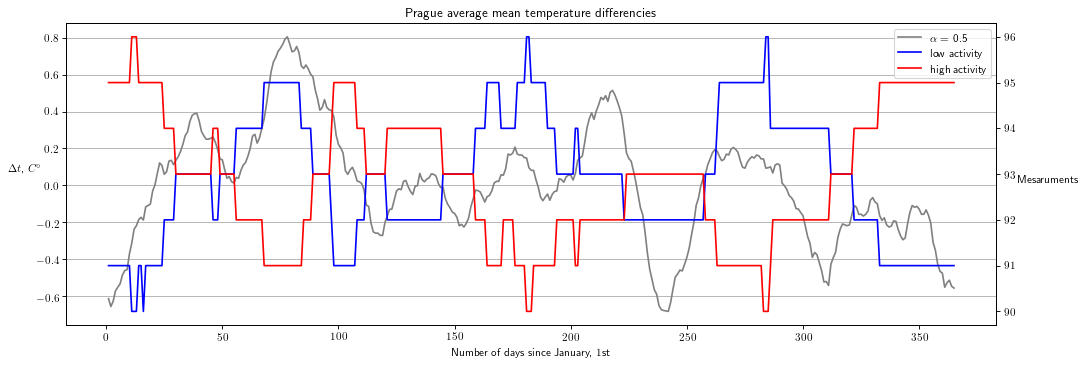

alpha = 0.25 average delta = -0.111095890411 median delta = -0.1


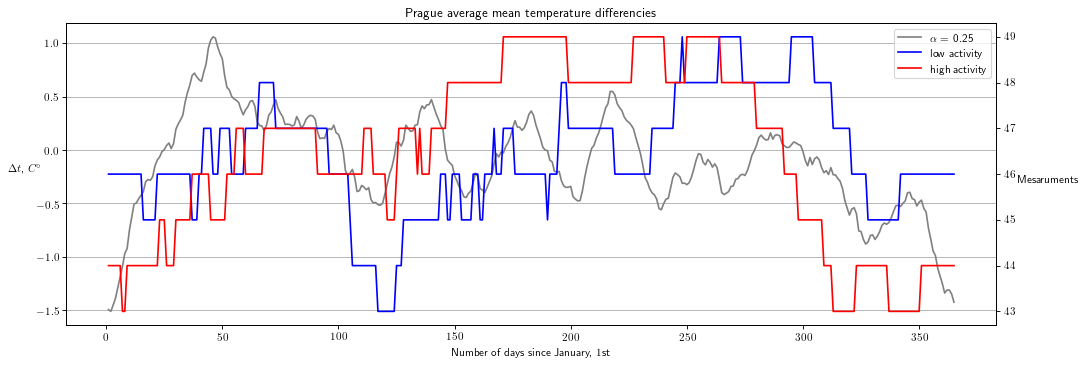

alpha = 0.1 average delta = -0.33 median delta = -0.4


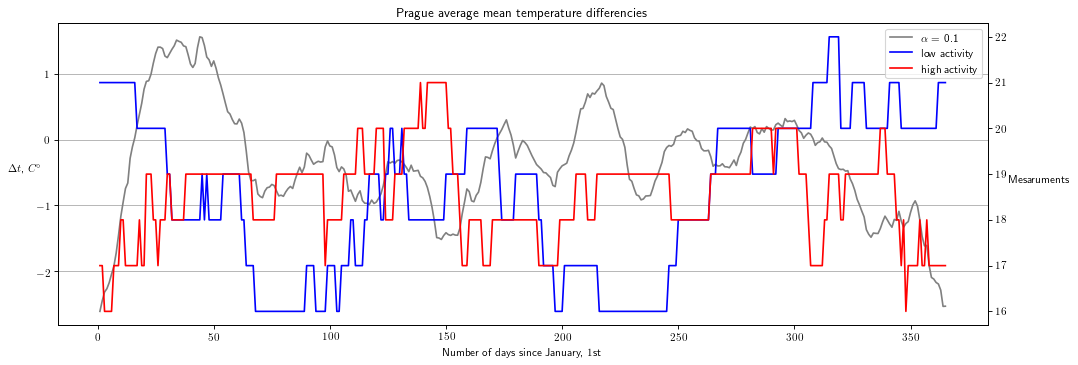

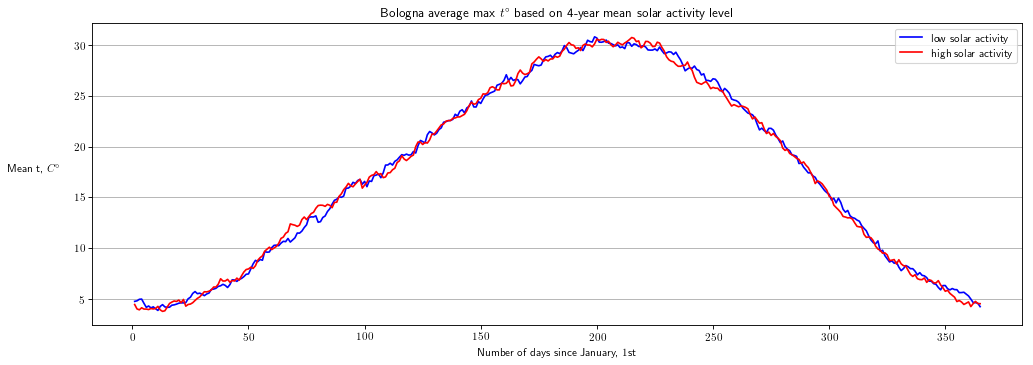

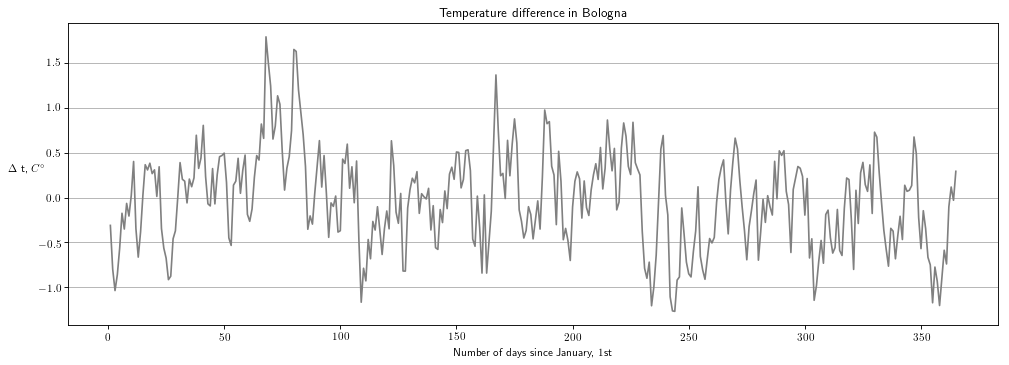

alpha = 0.5 average delta = 0.0116438356164 median delta = 0.0


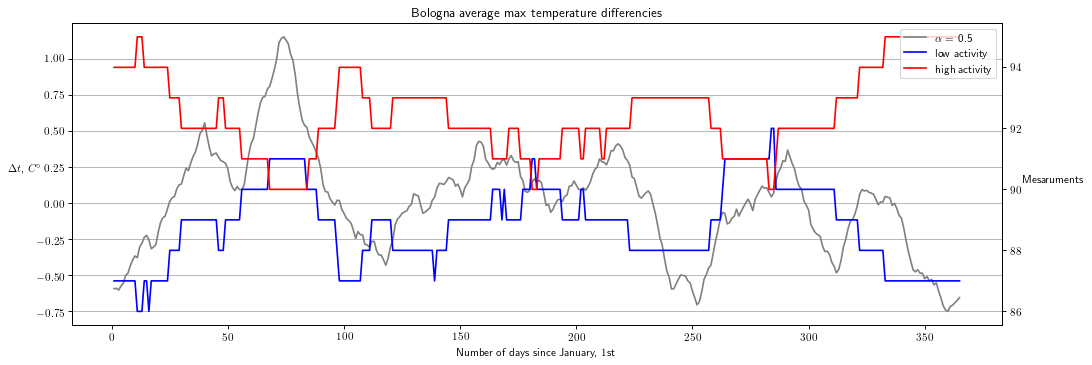

alpha = 0.25 average delta = -0.0394520547945 median delta = -0.05


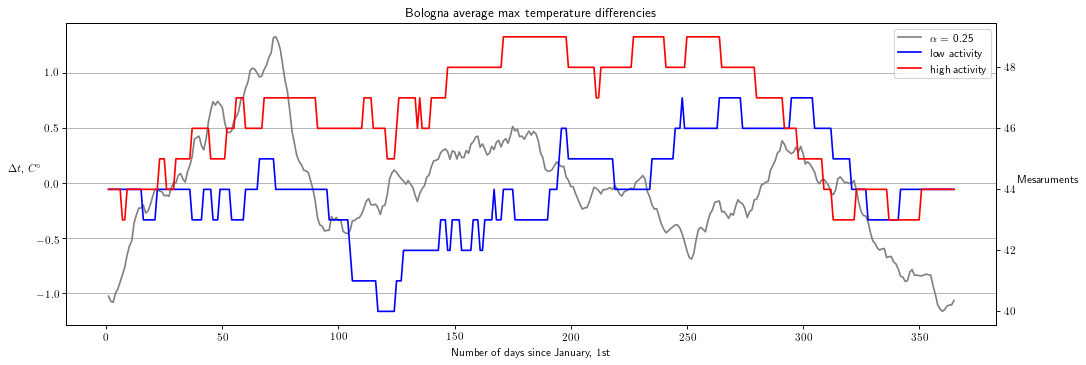

alpha = 0.1 average delta = -0.183287671233 median delta = -0.15


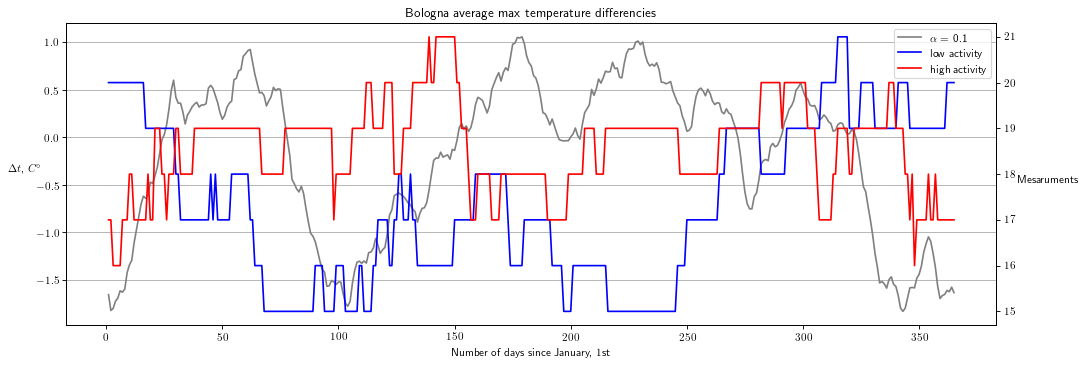

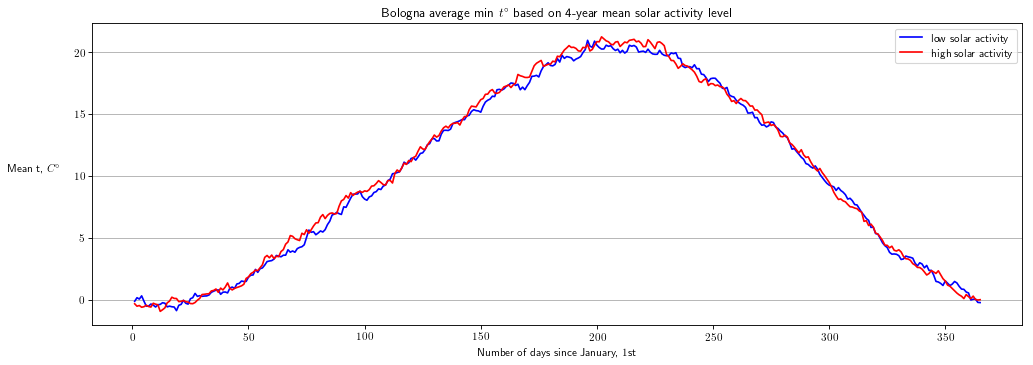

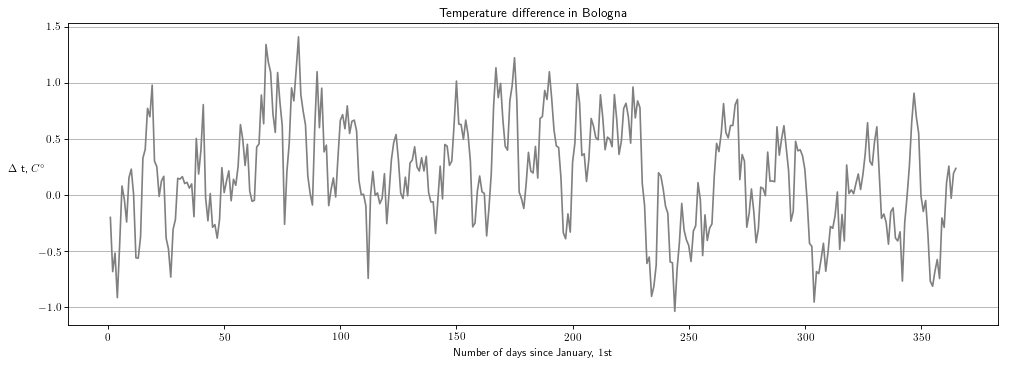

alpha = 0.5 average delta = 0.206438356164 median delta = 0.2


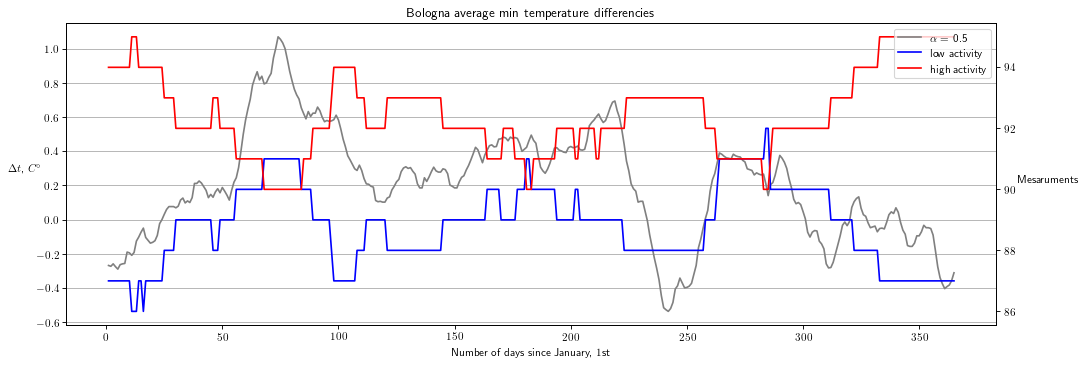

alpha = 0.25 average delta = 0.114109589041 median delta = 0.15


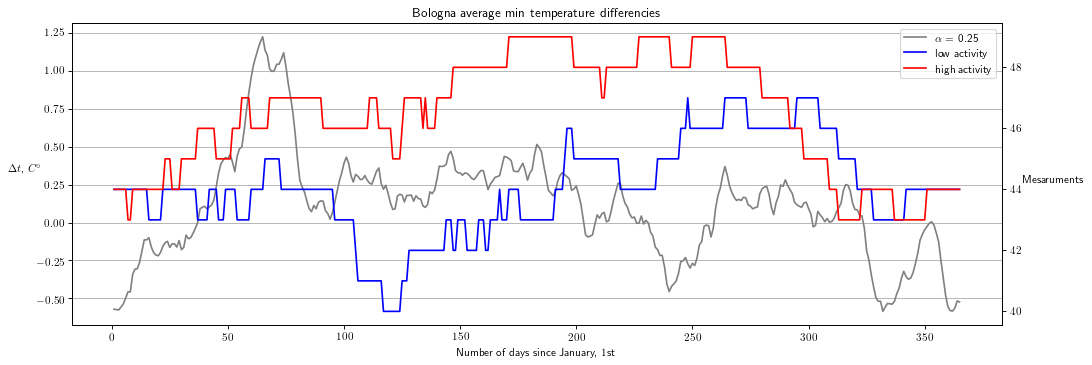

alpha = 0.1 average delta = -0.187260273973 median delta = -0.15


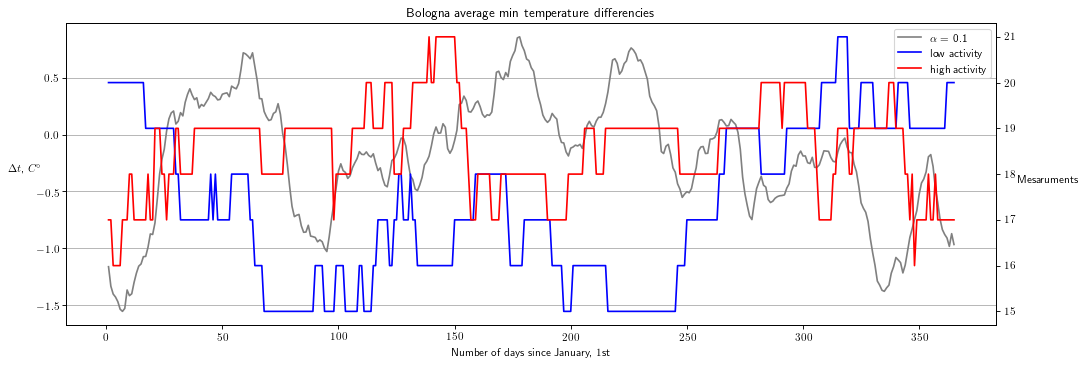

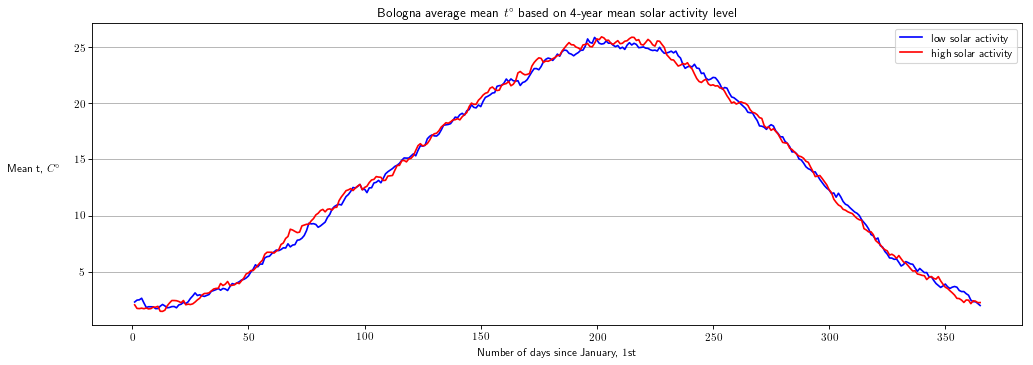

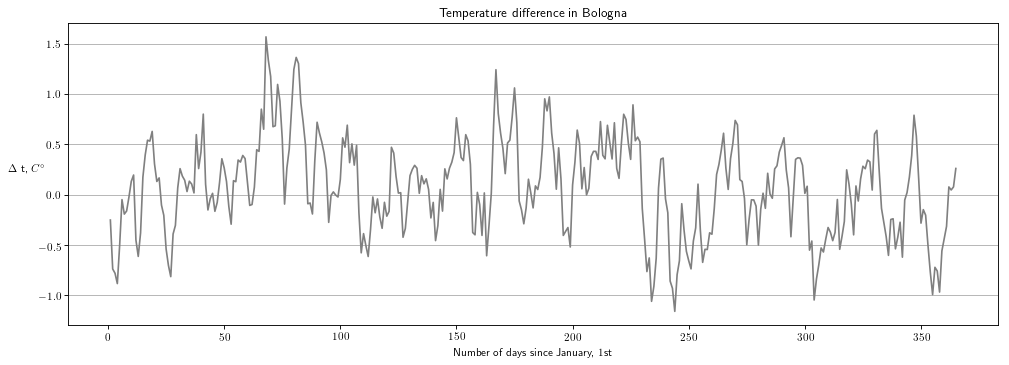

alpha = 0.5 average delta = 0.106301369863 median delta = 0.1


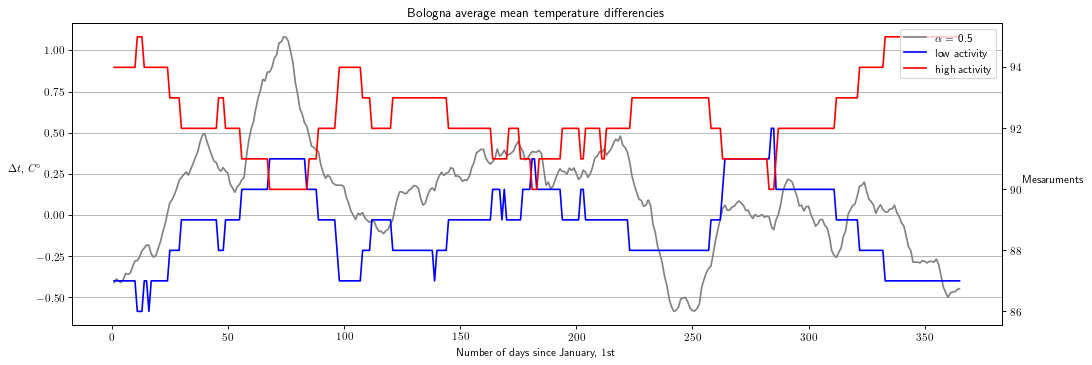

alpha = 0.25 average delta = -0.00849315068493 median delta = 0.0


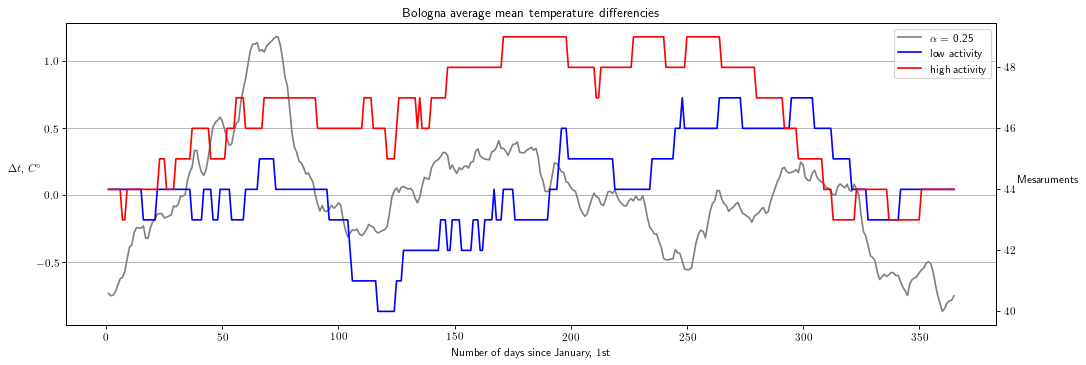

alpha = 0.1 average delta = -0.189863013699 median delta = -0.1


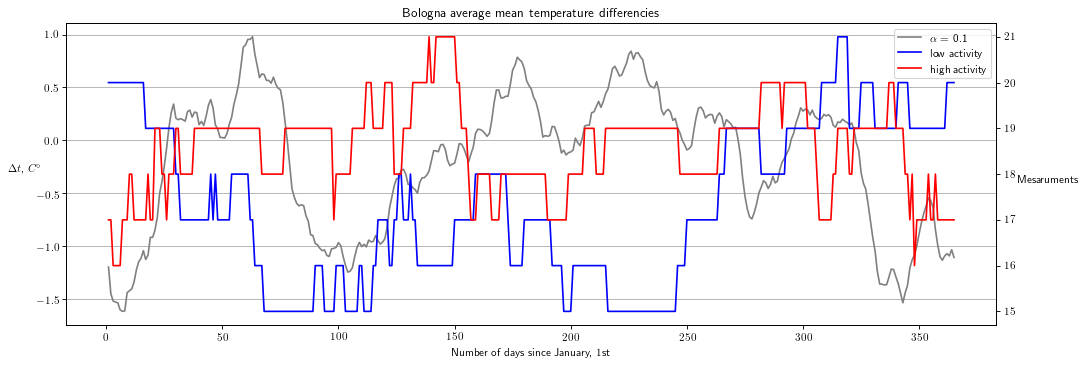

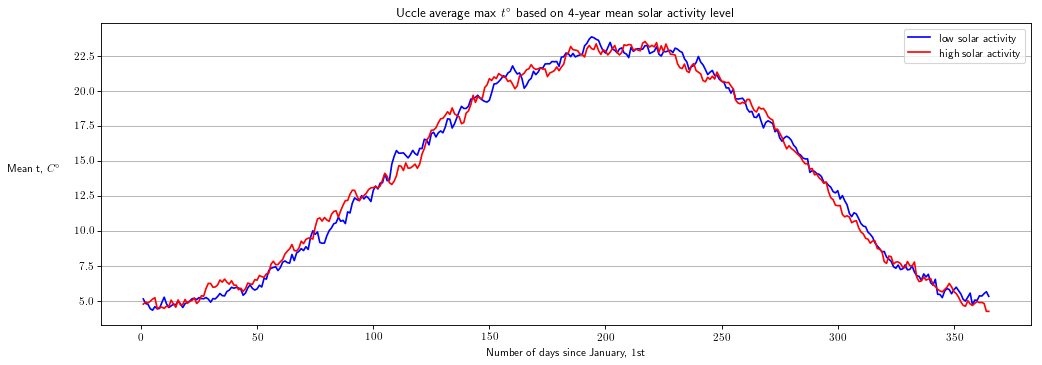

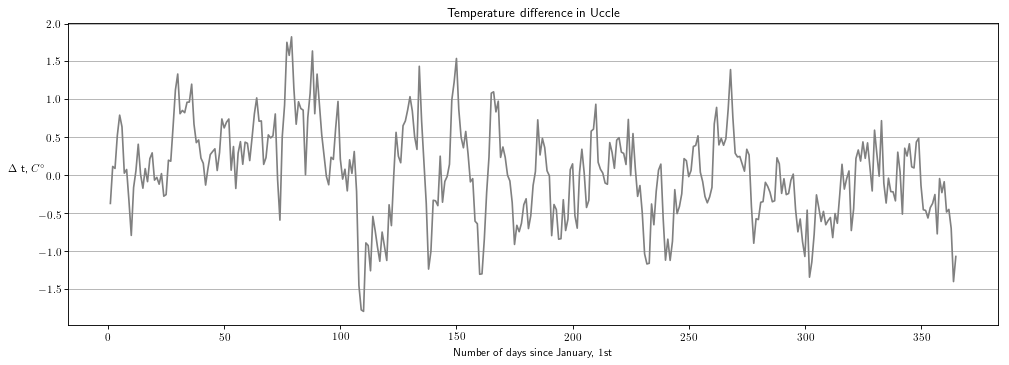

alpha = 0.5 average delta = 0.0569863013699 median delta = 0.05


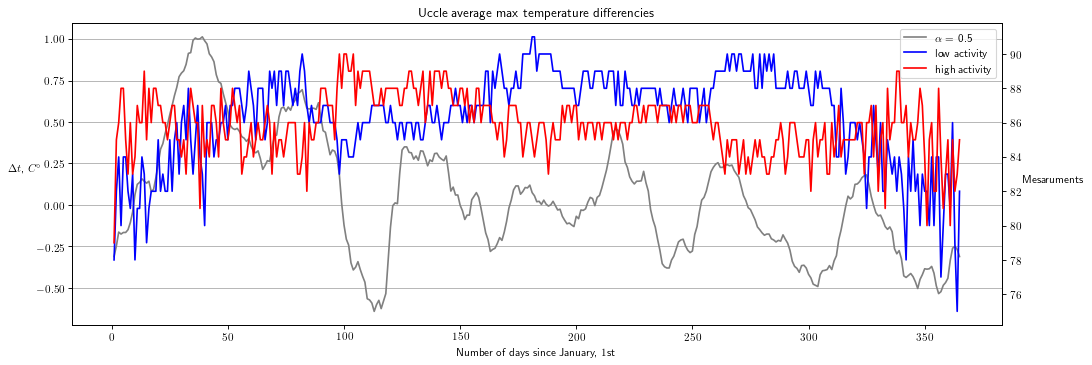

alpha = 0.25 average delta = 0.15602739726 median delta = 0.2


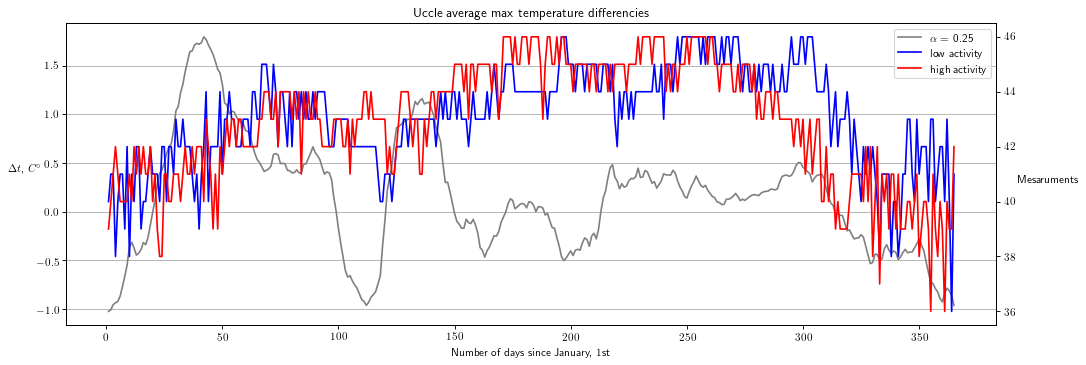

alpha = 0.1 average delta = -0.0768493150685 median delta = 0.0


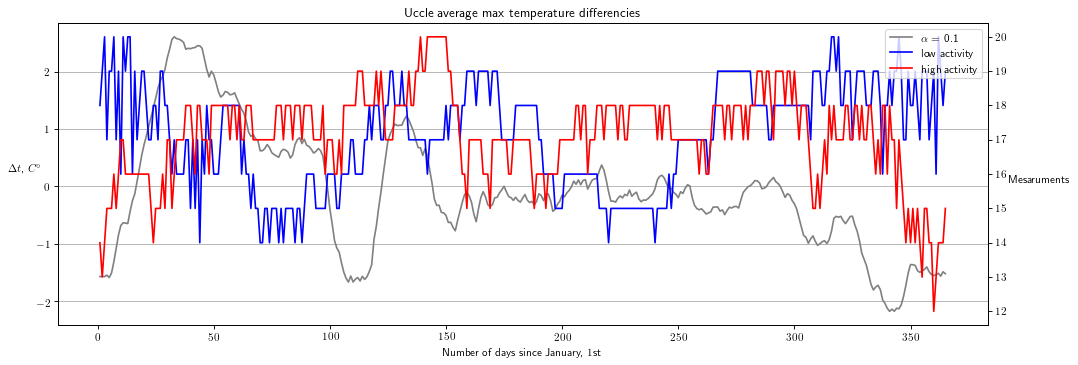

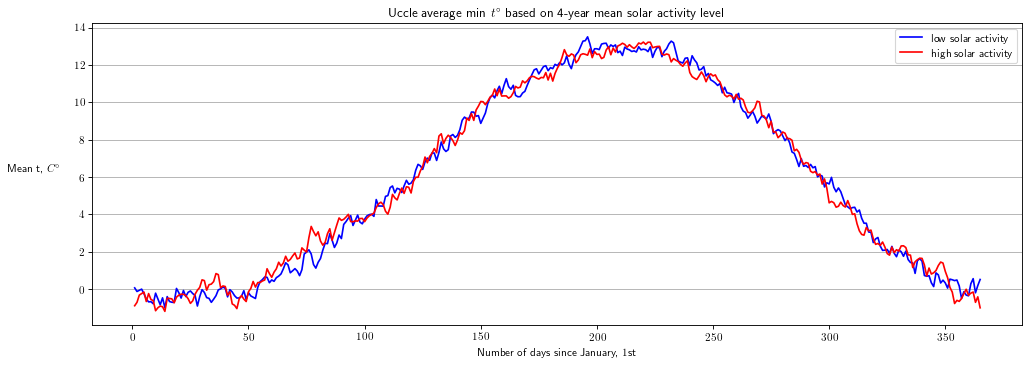

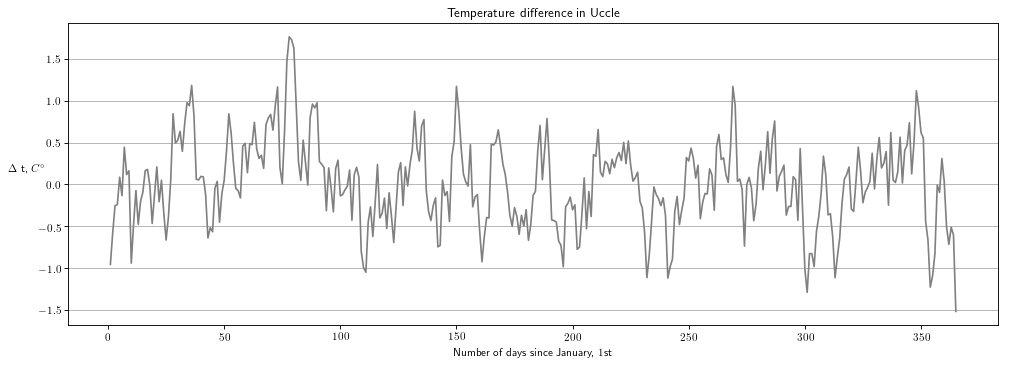

alpha = 0.5 average delta = 0.0241095890411 median delta = 0.05


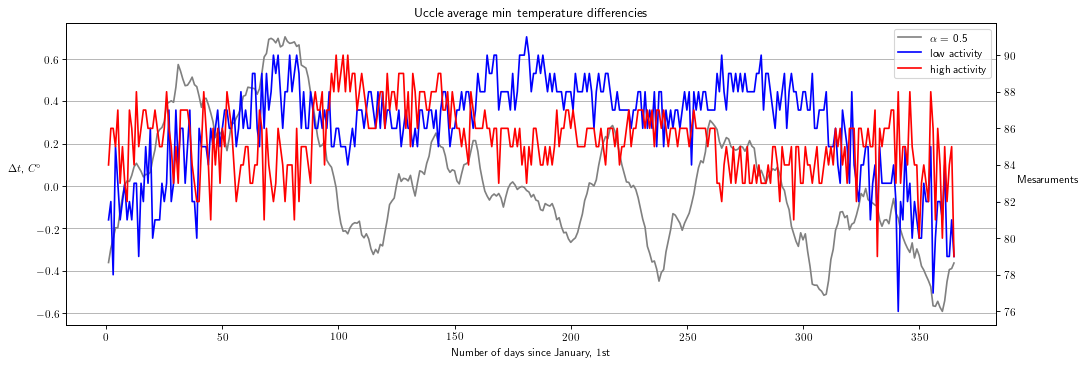

alpha = 0.25 average delta = 0.110410958904 median delta = 0.1


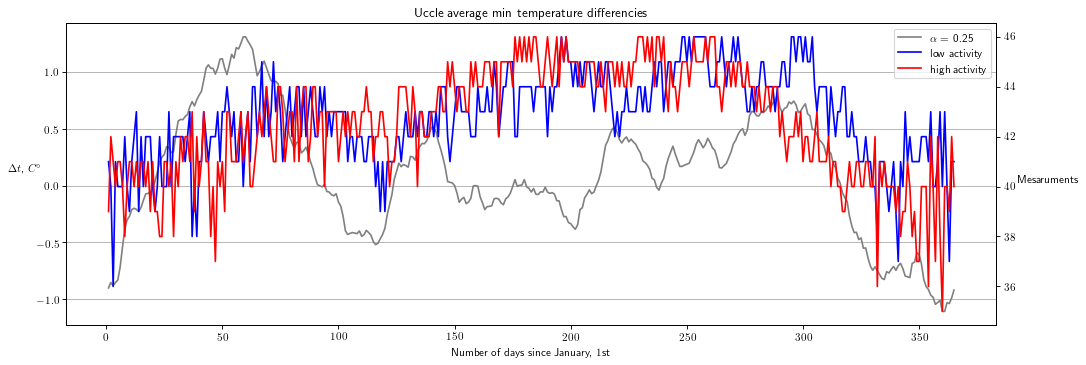

alpha = 0.1 average delta = -0.0667123287671 median delta = 0.1


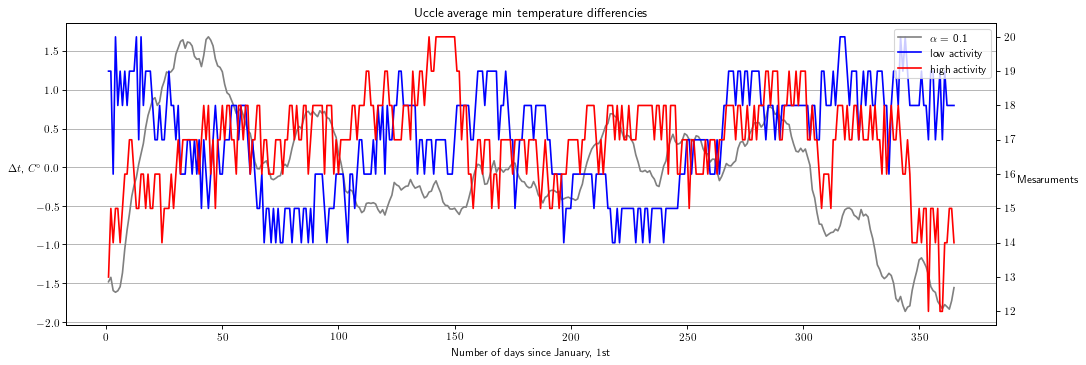

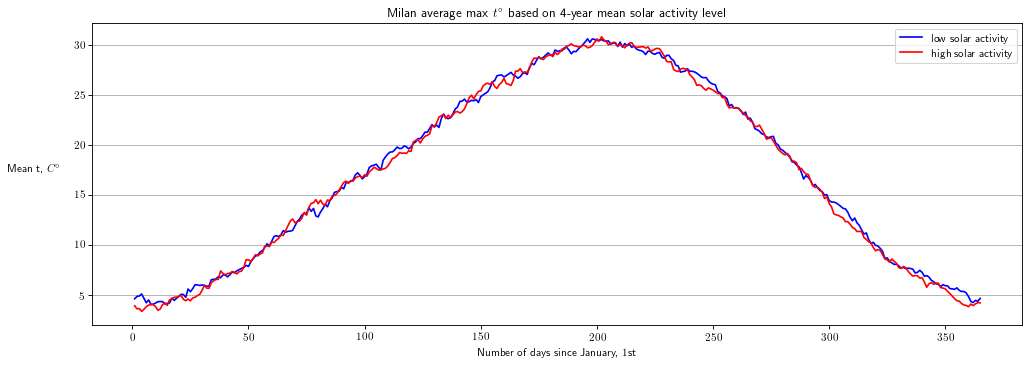

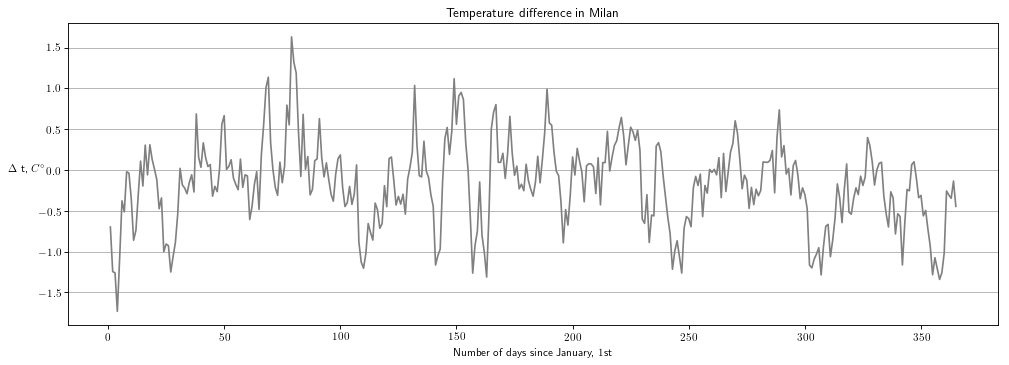

alpha = 0.5 average delta = -0.150410958904 median delta = -0.1


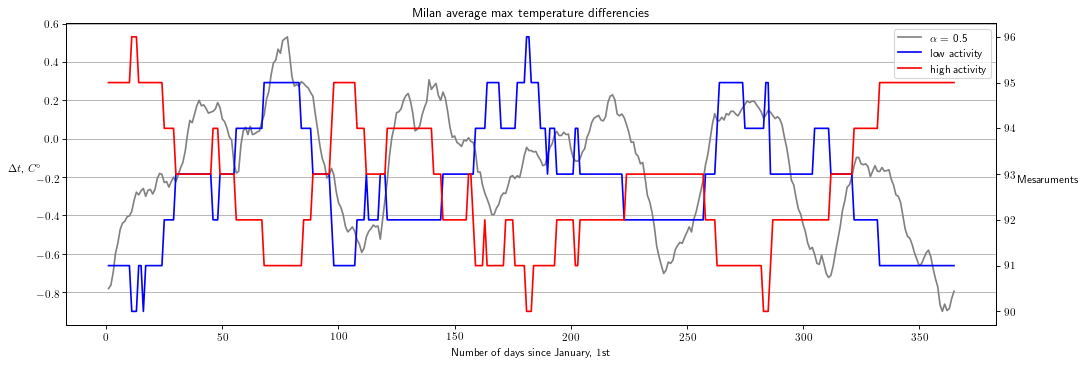

alpha = 0.25 average delta = -0.163698630137 median delta = -0.1


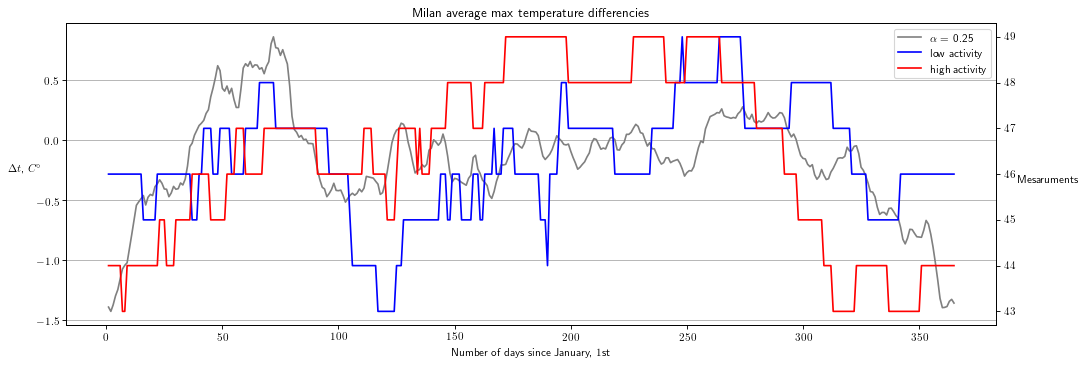

alpha = 0.1 average delta = -0.340547945205 median delta = -0.4


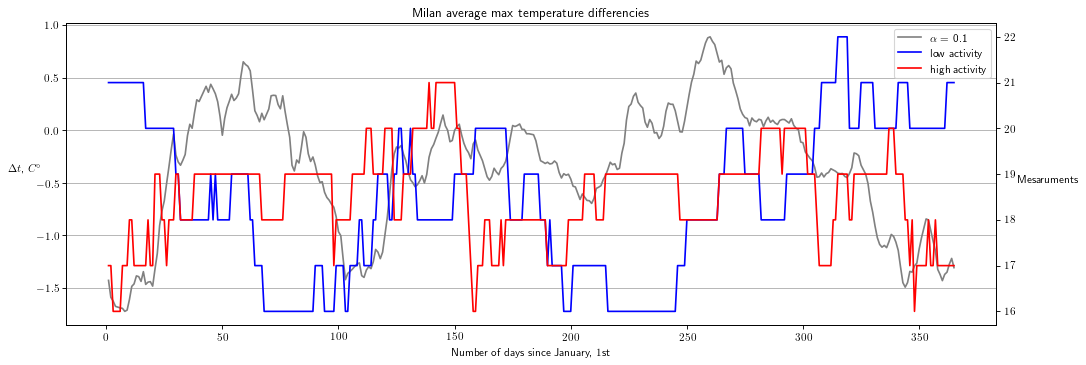

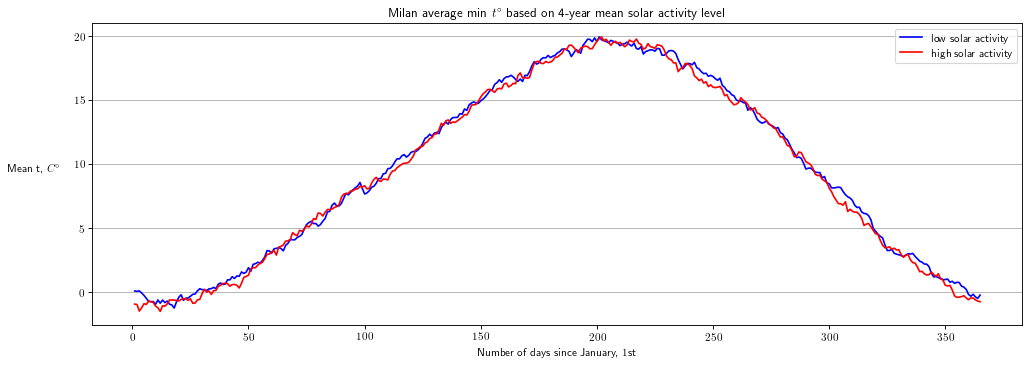

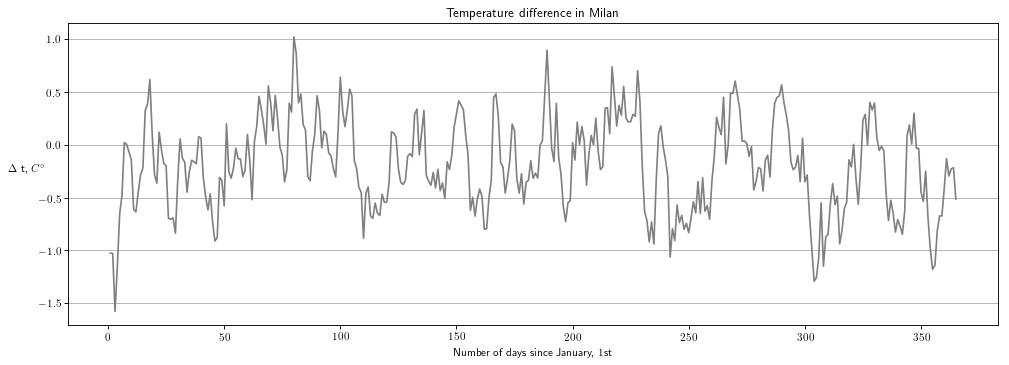

alpha = 0.5 average delta = -0.115479452055 median delta = -0.1


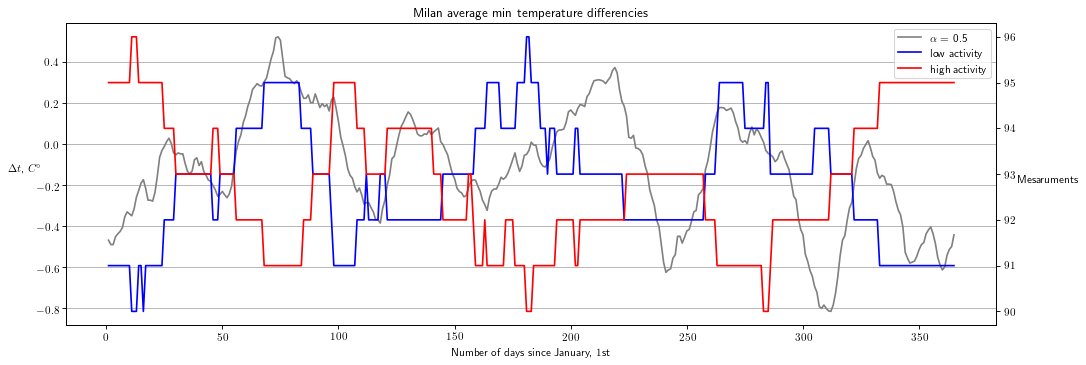

alpha = 0.25 average delta = -0.267671232877 median delta = -0.25


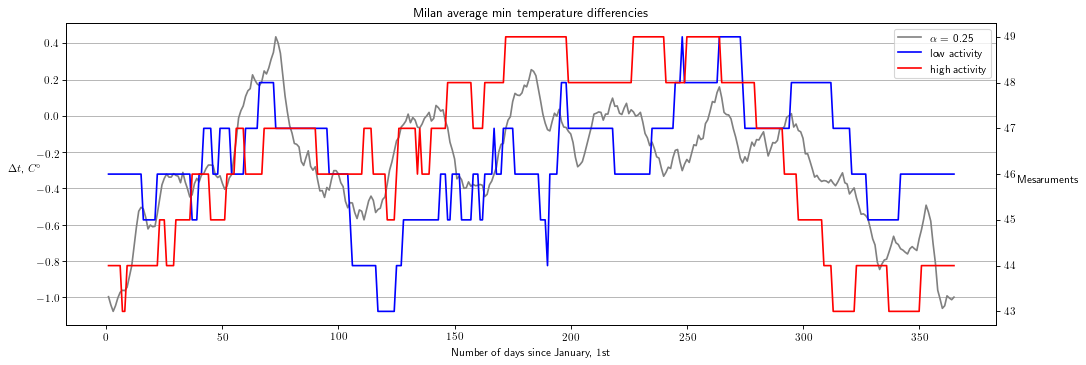

alpha = 0.1 average delta = -0.382739726027 median delta = -0.3


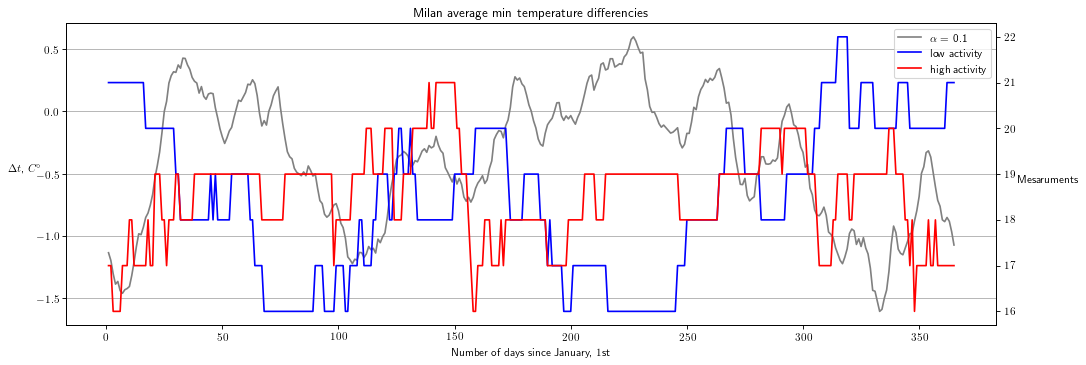

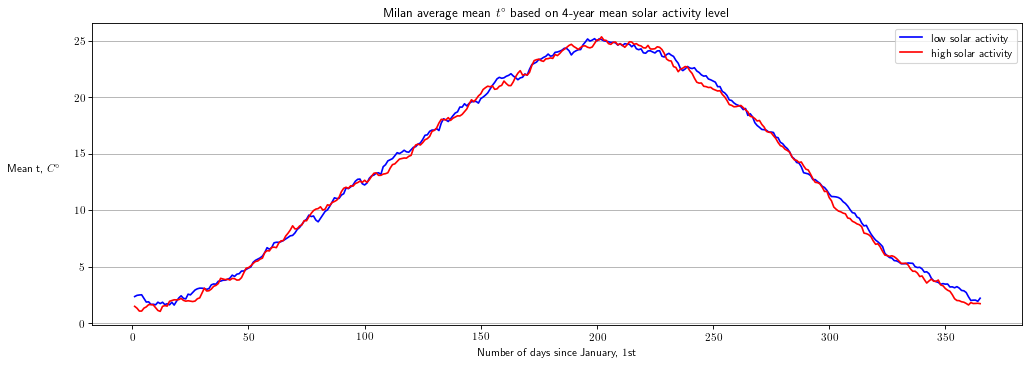

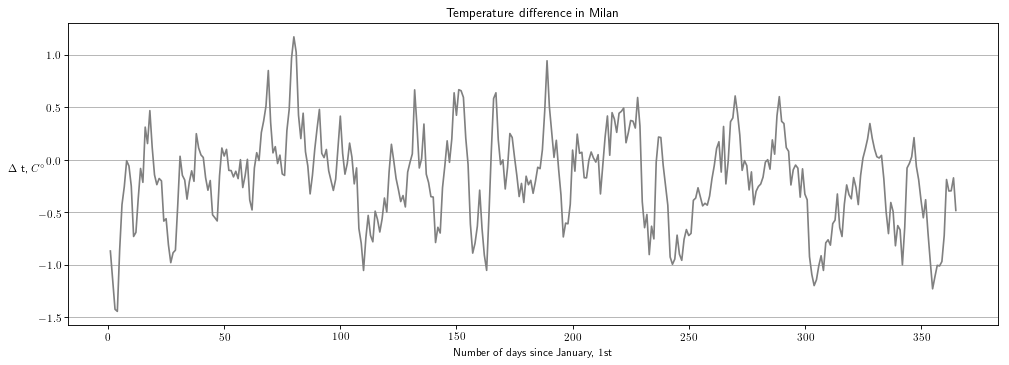

alpha = 0.5 average delta = -0.109315068493 median delta = -0.1


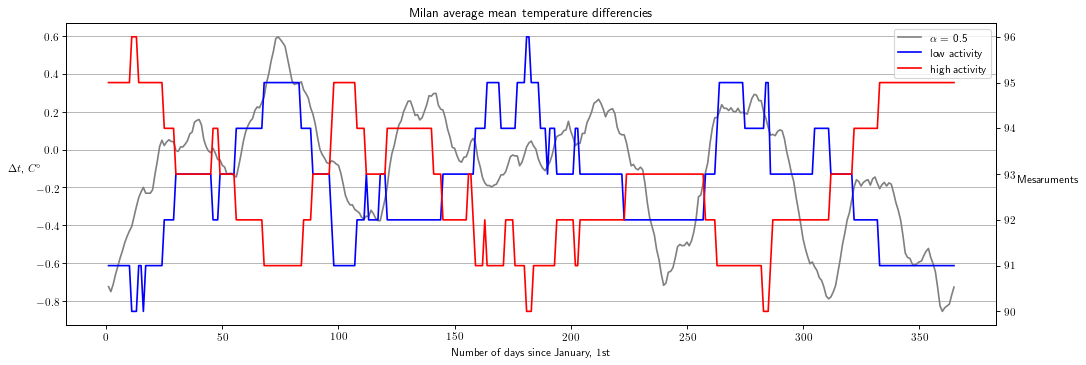

alpha = 0.25 average delta = -0.217671232877 median delta = -0.15


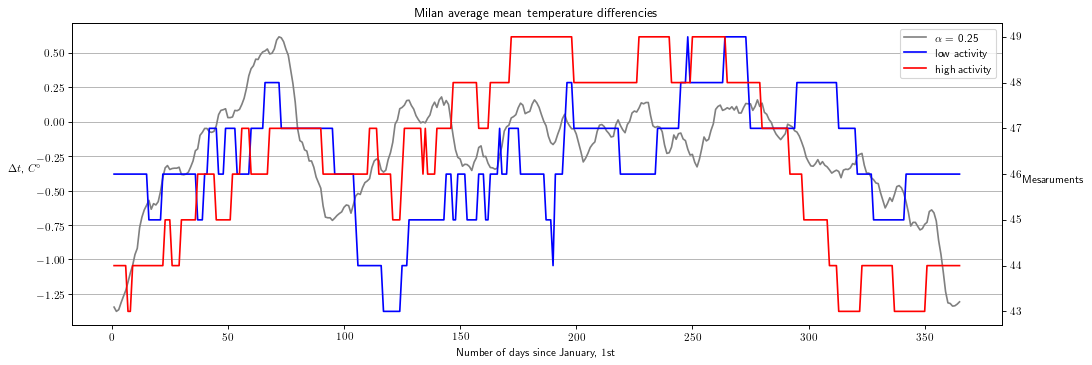

alpha = 0.1 average delta = -0.353287671233 median delta = -0.3


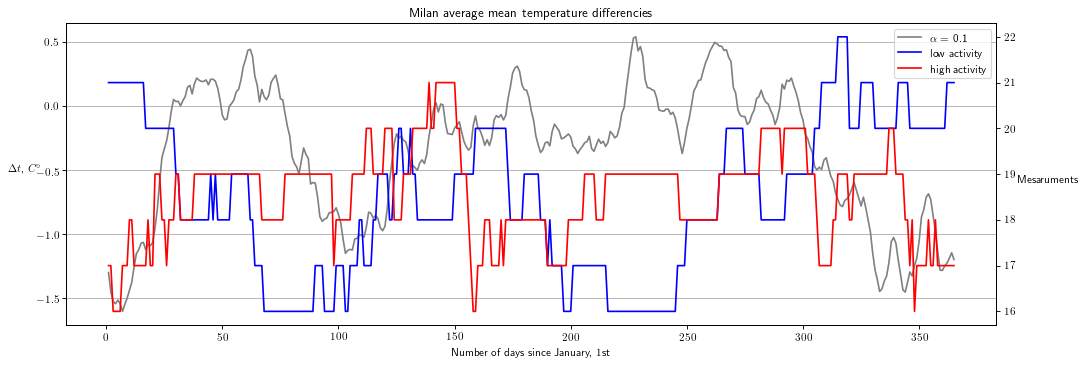

In [12]:
for city in cities:
    for case in cases[city]:
        low_activity, high_activity = GetActivityLevels(0.5)
        DrawMinMaxTemperatures(city, case, date_by_number, low_activity, high_activity)
        for alpha in parameters:
            low_activity, high_activity = GetActivityLevels(alpha)
            PrintDifferenceDayTemperature(city, case, alpha, date_by_number,
                                          low_activity, high_activity)

In [13]:
# хочется посмотреть на значения средней разницы температур в зависимости от времени и alpha

def MeanDayDiff(city, case, year_begin, year_end, date_by_number, low_activity, high_activity):
    mesaruments_low = [[] for i in range(DAYS_NUMBER)]
    mesaruments_high = [[] for i in range(DAYS_NUMBER)]
    
    f_in = open(GetFileName(city, case), "r")
    SkipFirstLines(f_in)
    
    for line in f_in:
        row = line.split(",")
        date, temperature = row[2], int(row[3])
        cur_year, month, day = int(date[:4]), int(date[4:6]), int(date[6:])
        
        if int(row[4]) != 9 and (month, day) != (2, 29):
            day = GetDayNumber(month, day)
            if year_begin <= cur_year < year_end:
                if (cur_year, day) in low_activity:
                    mesaruments_low[day].append(temperature)
                elif (cur_year, day) in high_activity:
                    mesaruments_high[day].append(temperature)
            elif cur_year >= year_end:
                break
    f_in.close()
    
    mean_low_years, mean_high_years, delta_median = [], [], []
    low = [np.mean(mesaruments_low[day]) for day in range(DAYS_NUMBER)]
    high = [np.mean(mesaruments_high[day]) for day in range(DAYS_NUMBER)]
    delta_temp = (np.array(high) - np.array(low)) / 10
    return np.median(delta_temp)

In [14]:
def MeanWeekDiff(city, case, year_begin, year_end, date_by_number, low_activity, high_activity):
    mesaruments_low = [[] for i in range(WEEKS_NUMBER)]
    mesaruments_high = [[] for i in range(WEEKS_NUMBER)]
    
    f_in = open(GetFileName(city, case), "r")
    SkipFirstLines(f_in)
    
    for line in f_in:
        row = line.split(",")
        date, temperature = row[2], int(row[3])
        cur_year, month, day = int(date[:4]), int(date[4:6]), int(date[6:])
        
        if int(row[4]) != 9 and (month, day) != (2, 29):
            week = GetWeekNumber(GetDayNumber(month, day))
            if year_begin <= cur_year < year_end:
                if (cur_year, day) in low_activity:
                    mesaruments_low[week].append(temperature)
                elif (cur_year, day) in high_activity:
                    mesaruments_high[week].append(temperature)
            elif cur_year >= year_end:
                break
    f_in.close()
    
    mean_low_years, mean_high_years, delta_median = [], [], []
    low = [np.mean(mesaruments_low[week]) for week in range(WEEKS_NUMBER)]
    high = [np.mean(mesaruments_high[week]) for week in range(WEEKS_NUMBER)]
    delta_temp = (np.array(high) - np.array(low)) / 10
    return np.median(delta_temp)

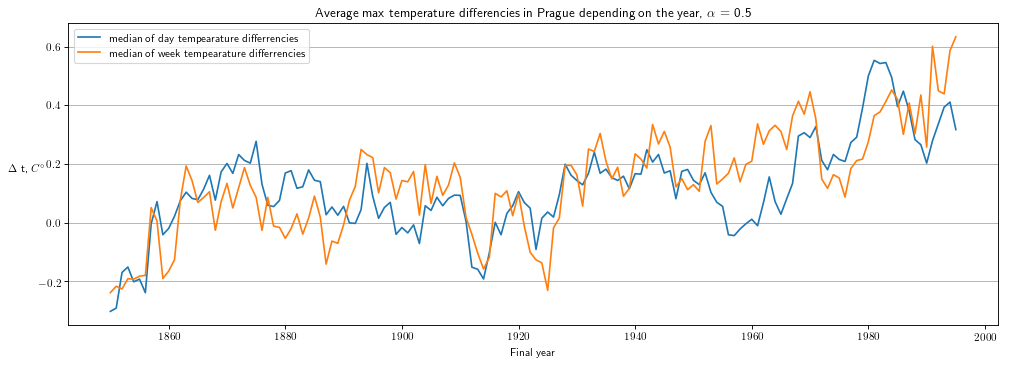

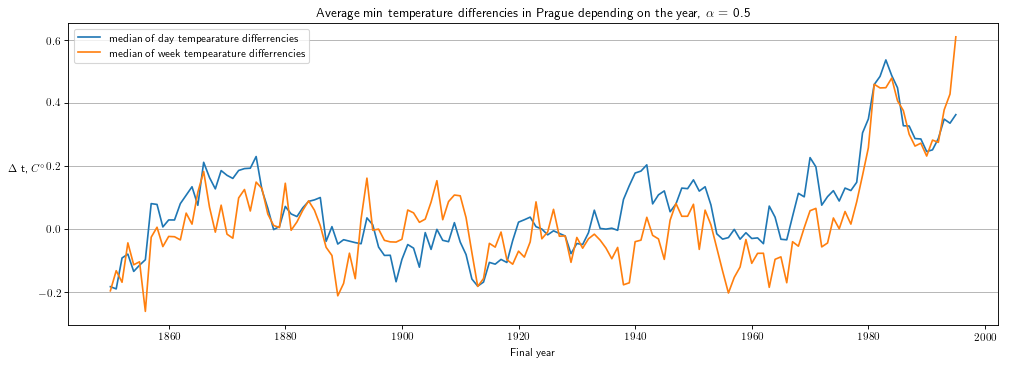

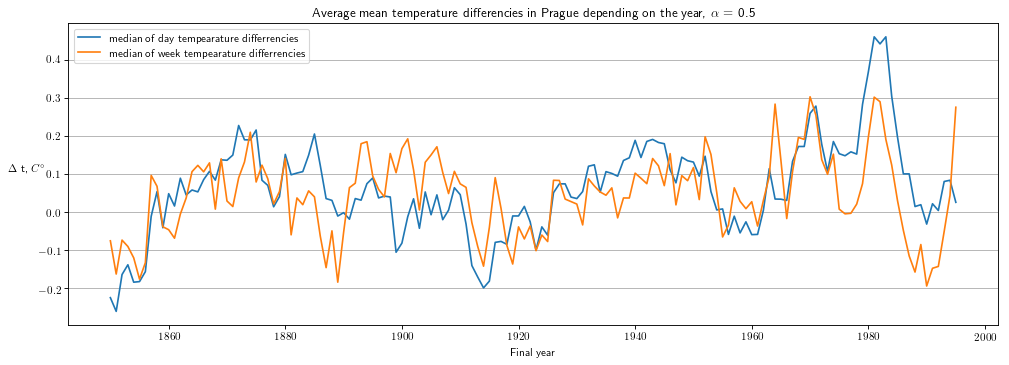

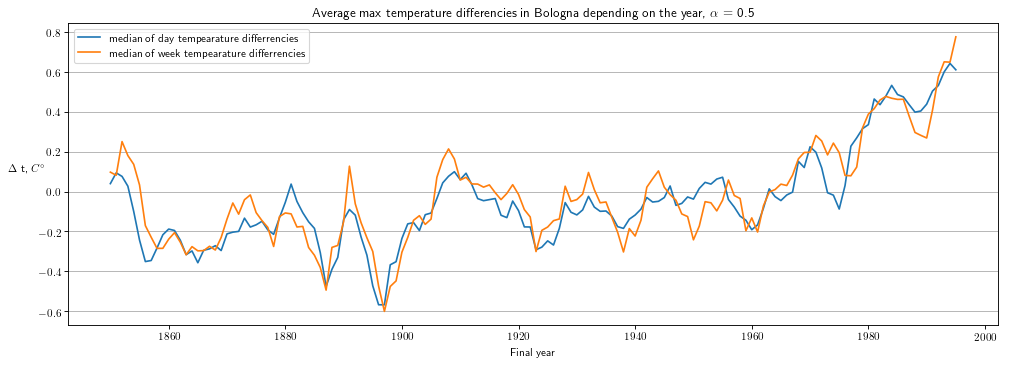

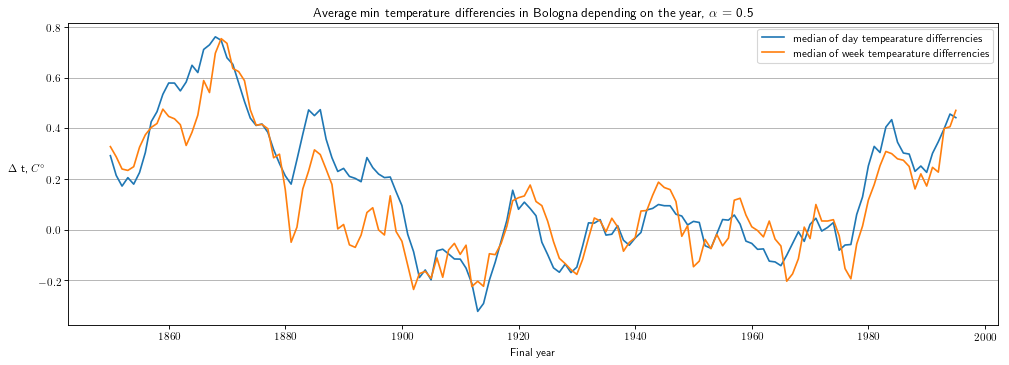

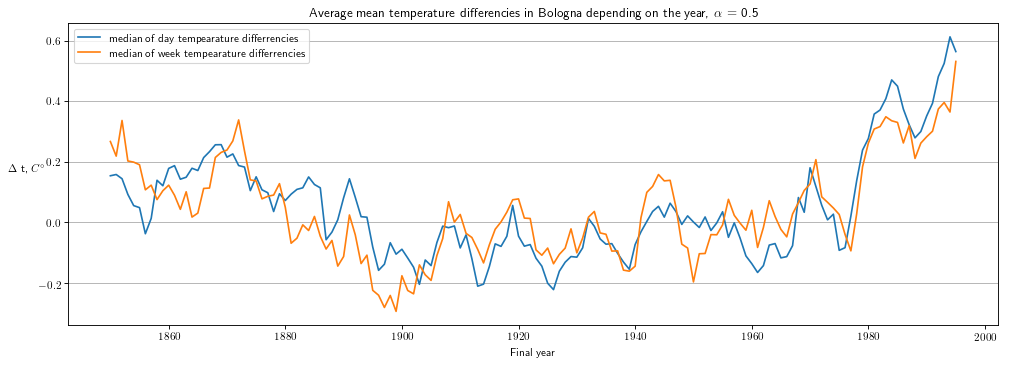

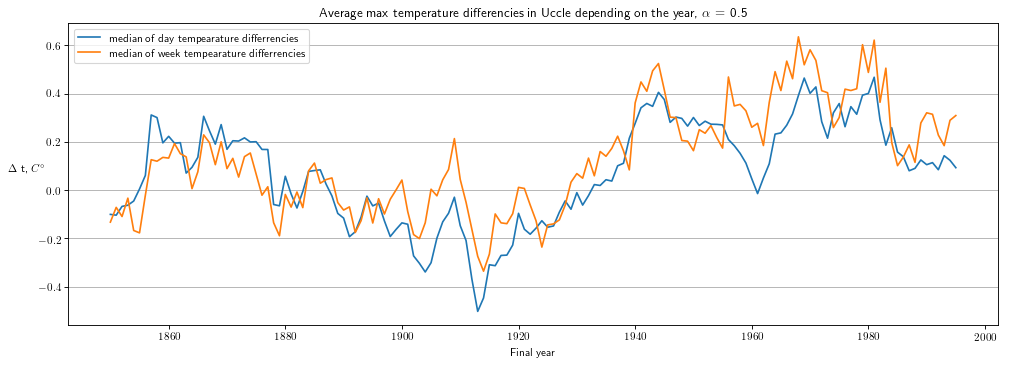

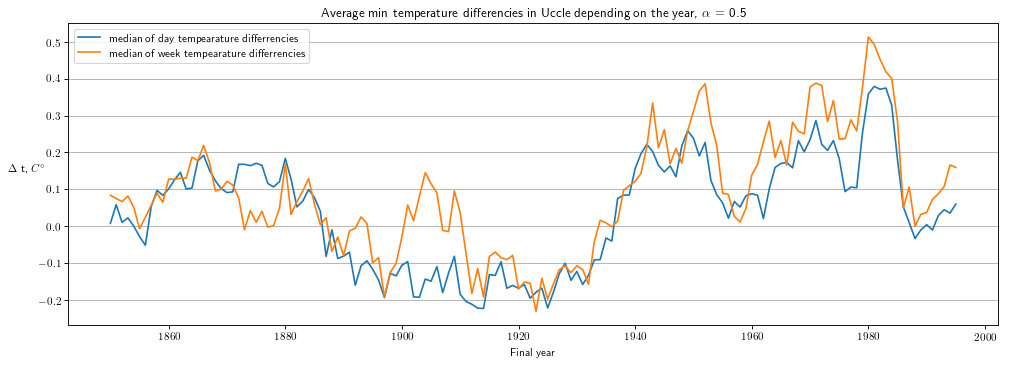

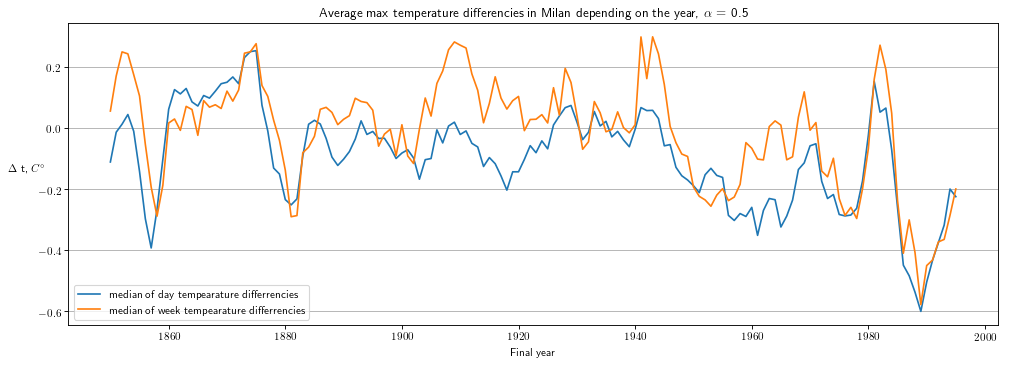

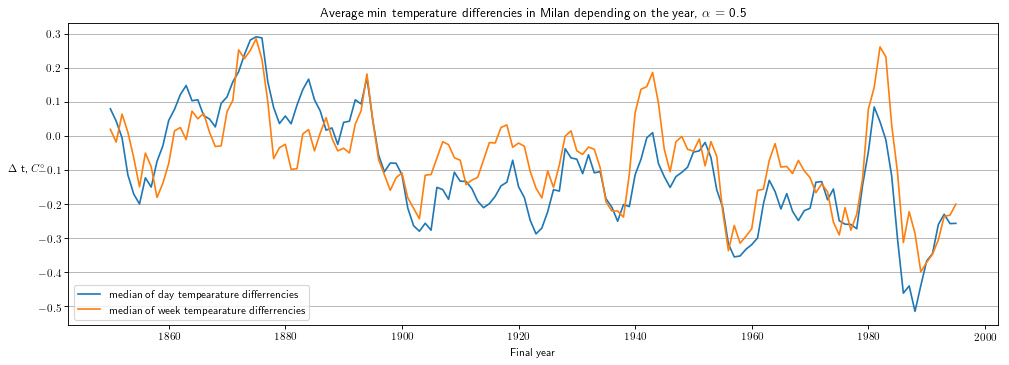

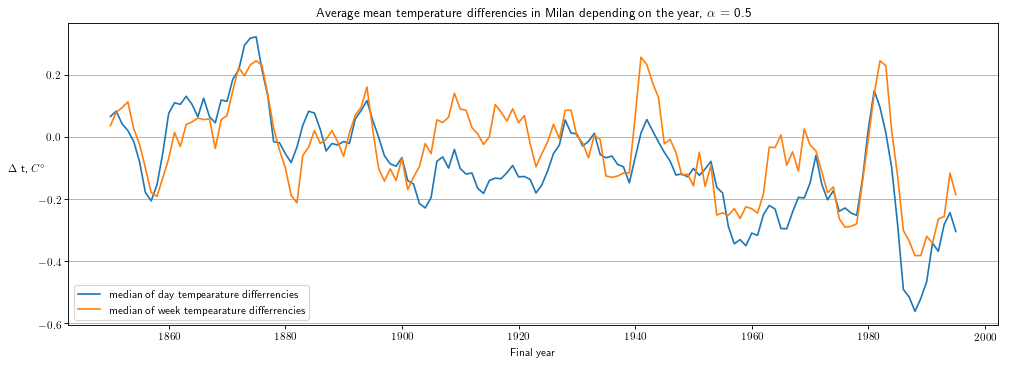

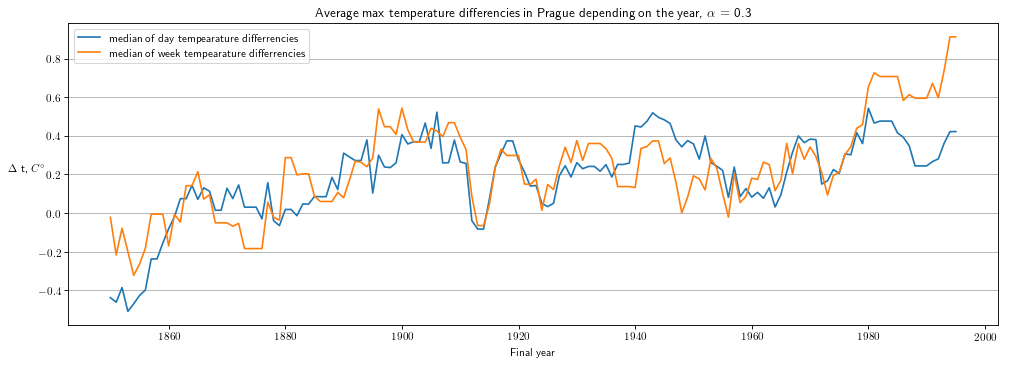

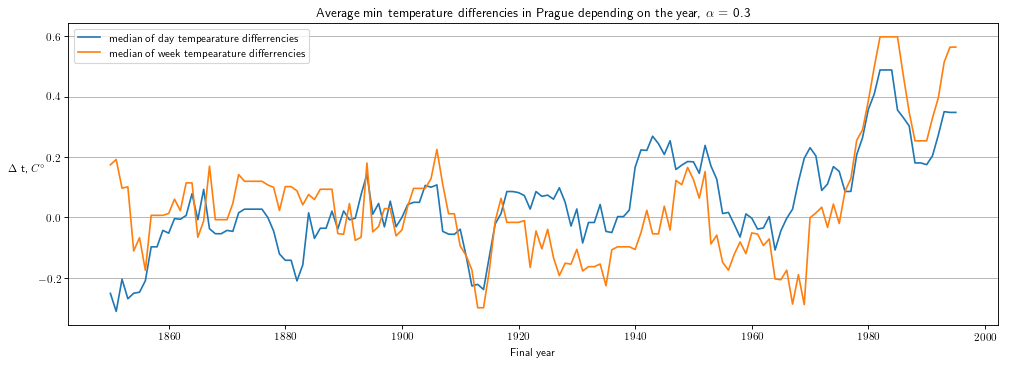

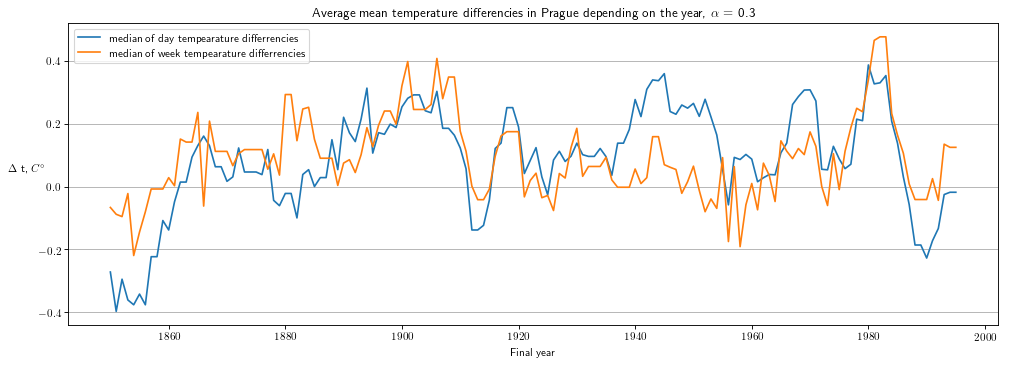

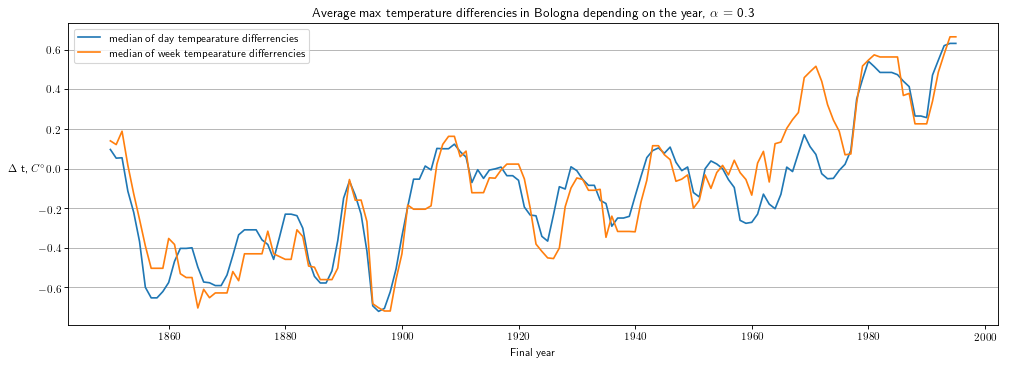

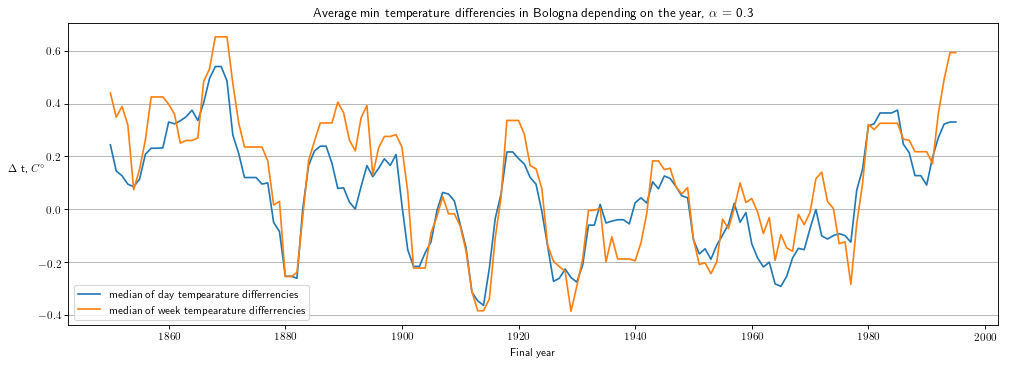

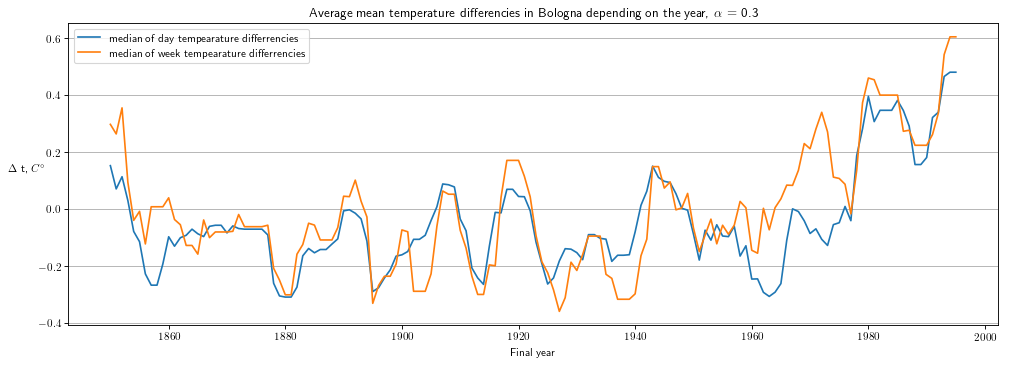

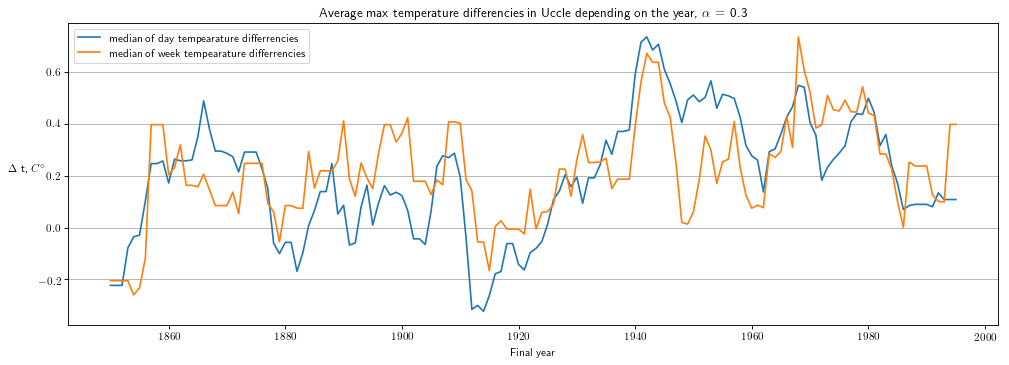

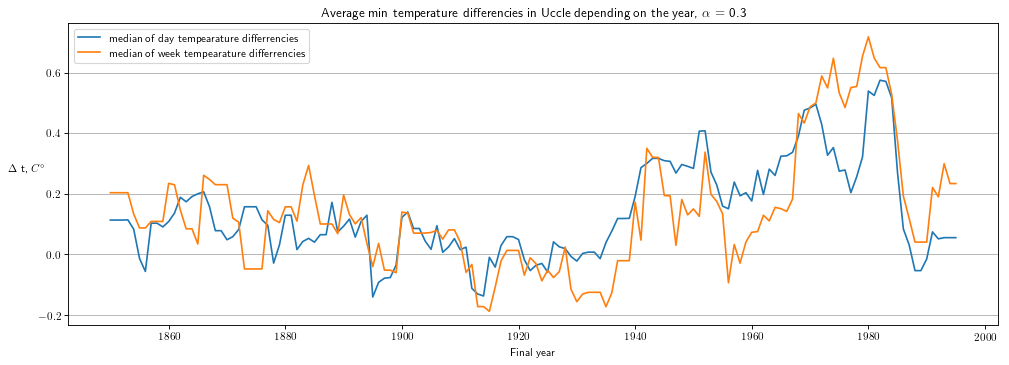

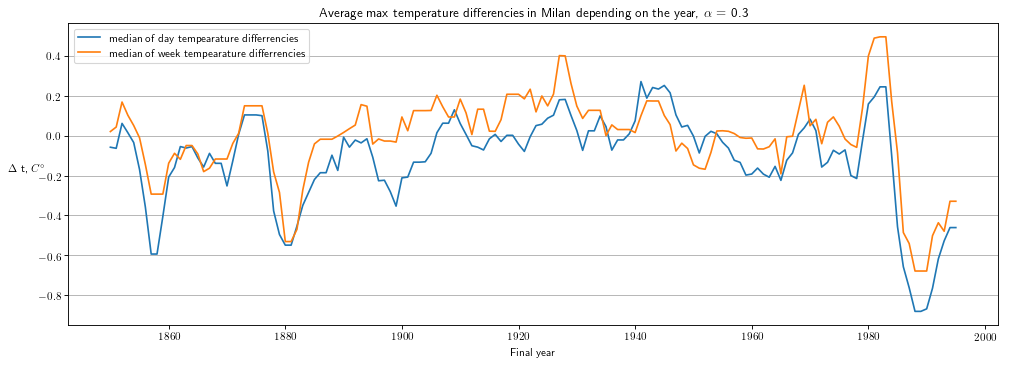

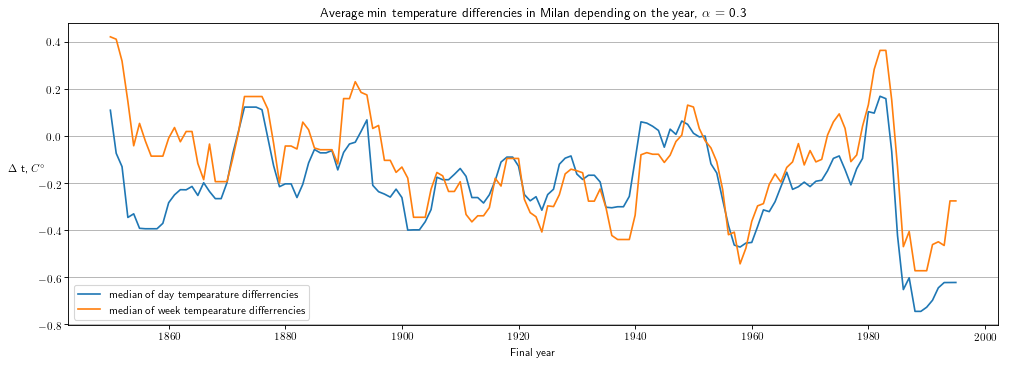

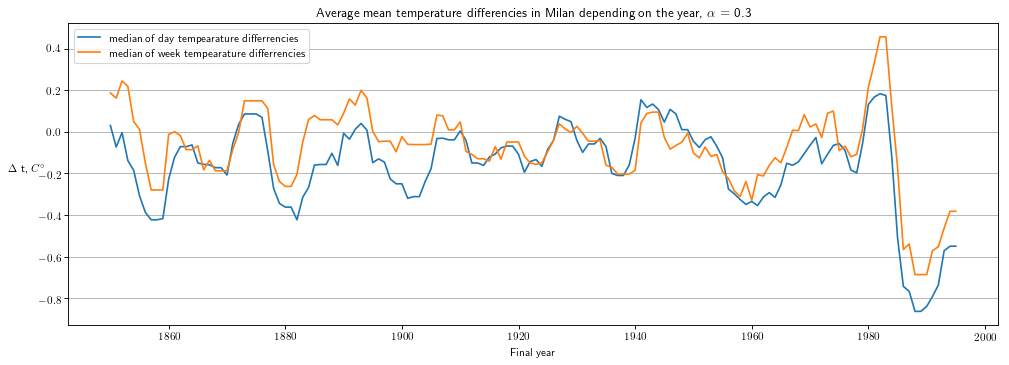

In [15]:
# посмотрим на значение средней разницы в температурах в плавающем окне в 4 цикла
period = 22

for alpha in [0.5, 0.3]:
    low_activity, high_activity = GetActivityLevels(alpha)
    for city in cities:
        for case in cases[city]:
        # для маленьких значений параметра недостаточно данных.
            file = GetPicFileName(city, case, "median_diff_changing_" + str(int(alpha * 100)))

            mean_d, median_d = [], []
            years, day_diff, week_diff = [], [], []

            for year in range(BEGIN + period + 10, END - period):
                begin, end = year - period, year + period + 1
                day_diff.append(MeanDayDiff(city, case, begin, end, date_by_number, low_activity, high_activity))
                week_diff.append(MeanWeekDiff(city, case, begin, end, date_by_number, low_activity, high_activity))
                years.append(year)

            fig = plt.figure(dpi = DPI, figsize = (SIZE_X, SIZE_Y))
            ax = plt.axes()
            ax.yaxis.grid(True)
            plt.title("Average " + case + " temperature differencies in " + city + 
                        " depending on the year, $\\alpha$ = " + str(alpha))
            plt.xlabel("Final year")
            plt.ylabel("$\Delta$ t, $C^{\circ}$", 
                     rotation='horizontal',
                     labelpad=10)
            plt.plot(np.array(years),
                    np.array(day_diff),
                    label = "median of day tempearature differrencies")
            plt.plot(np.array(years),
                    np.array(week_diff),
                    label = "median of week tempearature differrencies")

            plt.legend(loc="best")
            plt.show()
            fig.savefig(file)